# Pipeline for High-z Radio Galaxies 10: SHAP values for base models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
from sklearn.model_selection import train_test_split
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
from joblib import dump, load
import pandas as pd
import shap
import fasttreeshap
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

---

In [4]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True
use_calibration     = True
use_high_z_sources  = False  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.
use_unknown         = False  # False for using previously confirmed sources (AGN, Galaxies)

### Load data

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [5]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Test_Train'  # Validation, Training, Test, Test_Train
if used_area == 'HETDEX':
    subset_str   = f'_{HETDEX_subset}'
if used_area != 'HETDEX':
    subset_str   = '_'

In [6]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [7]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Fint_VLAS82',\
                       'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR',\
                       'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS', 'Stotal_TGSS',\
                       'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed',\
                       'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [8]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [9]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [10]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [11]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

#### Select relevant sources

In [12]:
if use_high_z_sources:  # Only use high-z AGN
    # filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= gv.high_z_limit)
    filter_selection   = np.array(full_catalog_df.loc[:, 'Z'] >= 4.0) & np.array(full_catalog_df.loc[:, 'class'] == 1)
    full_catalog_df    = full_catalog_df.loc[filter_selection]
    high_z_str         = '_high_z'
if not use_high_z_sources:
    high_z_str         = ''

In [13]:
if not use_high_z_sources:
    if used_area == 'HETDEX':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'is_AGN', use_calibration=use_calibration)
        print('Shape of used data in HETDEX')
        print('-' * 65)
        print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
        print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
        print(f'Training data:                                    {train_df.shape}')
        print(f'Testing data:                                     {test_df.shape}')
        if use_calibration:
            print(f'Calibration data:                                 {calibration_df.shape}')
        print(f'Validation data:                                  {validation_df.shape}')
        print('-' * 65)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test_Train': train_test_df,\
                            'Validation': validation_df, 'Calibration': calibration_df}
        full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 94)
Data for Modeling (Train, Test, and Calibration): (66727, 94)
Training data:                                    (53381, 94)
Testing data:                                     (6673, 94)
Calibration data:                                 (6673, 94)
Validation data:                                  (16682, 94)
-----------------------------------------------------------------

Using Test_Train data from HETDEX


In [14]:
if not use_high_z_sources:
    if used_area != 'HETDEX':
        filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                           (full_catalog_df.loc[:, 'class'] == 1) |\
                           (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
        unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
        full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [15]:
full_catalog_df          = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

In [16]:
if not use_high_z_sources:
    if use_unknown:
        full_catalog_df = unknown_cat_df
    filter_selection   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

In [17]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (66727, 90)
--------------------------------------------------
Thus, it has 66,727 sources and 90 features.


### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  #
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # sources with predicted z >= 3.6

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star_logit = np.log(gv.star_thresh  / (1 - gv.star_thresh))
threshold_AGN_logit      = np.log(gv.AGN_thresh   / (1 - gv.AGN_thresh))
threshold_radio_logit    = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

#### Predictions

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=gv.star_thresh, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [21]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=gv.AGN_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [22]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=gv.radio_thresh, raw_score=True, round=10)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [23]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=8)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [24]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [26]:
run_shap_AGN_base    = True
run_shap_radio_base  = True
run_shap_z_base      = True
run_shap_high_z_base = True

In [27]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [28]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [29]:
if run_shap_AGN_base:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 1,000


In [30]:
if run_shap_AGN_base:
    base_models_names_AGN = gf.get_base_estimators_names(AGN_gal_clf)

In [31]:
if run_shap_AGN_base:
    reduced_data_AGN    = full_catalog_df.loc[filter_pred_no_str].sample(n=sub_size_AGN, random_state=gv.seed).copy()
    display(reduced_data_AGN.loc[:, ['class', 'pred_class']].describe())
    reduced_data_AGN_df = gf.preprocess_data(AGN_gal_clf, reduced_data_AGN, base_models_names_AGN)
    reduced_cols_AGN    = reduced_data_AGN_df.columns.drop(base_models_names_AGN)

class  pred_class
count  1000.000000  1000.00000
mean      0.374000     0.37800
std       0.484106     0.48513
min       0.000000     0.00000
25%       0.000000     0.00000
50%       0.000000     0.00000
75%       1.000000     1.00000
max       1.000000     1.00000

Use FastTreeSHAP package

In [32]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                   n_jobs=12)  # No data

In [33]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=base_models_names_AGN), check_additivity=False)

Working with base model xgboost
Working with base model et
Working with base model rf
Working with base model gbc


In [34]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        print(f'{model: <10}\t: {np.array([explainers_AGN_base[model].expected_value]).flatten()[-1]: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	: -1.1919
et        	:  0.3387
rf        	:  0.3388
gbc       	: -1.3636


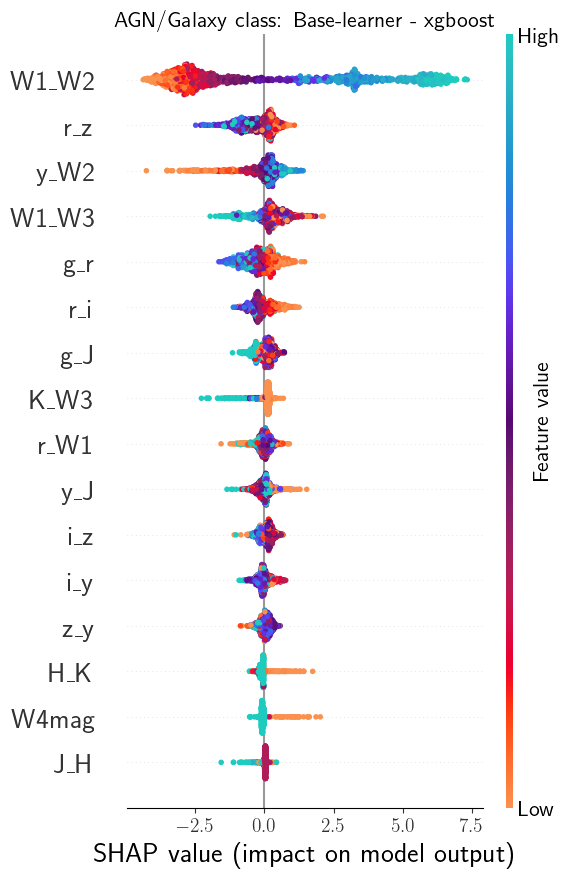

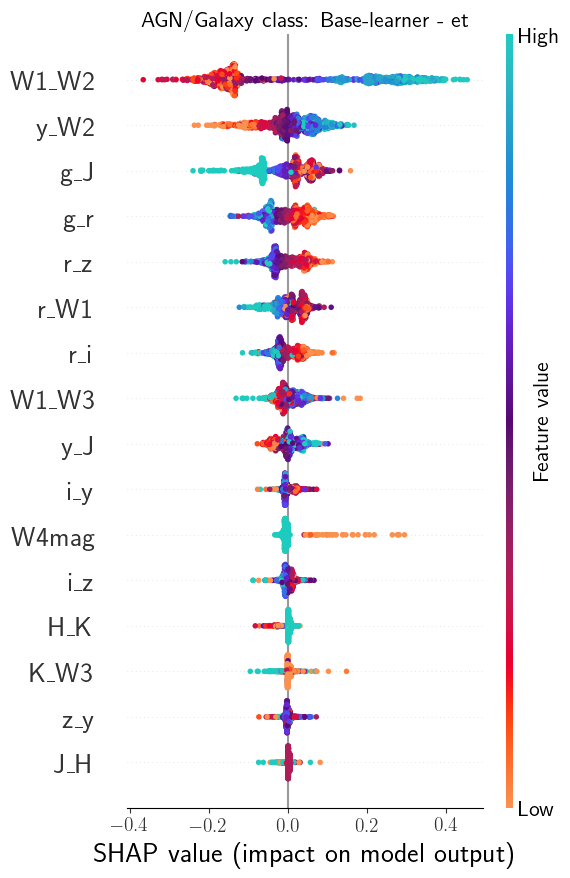

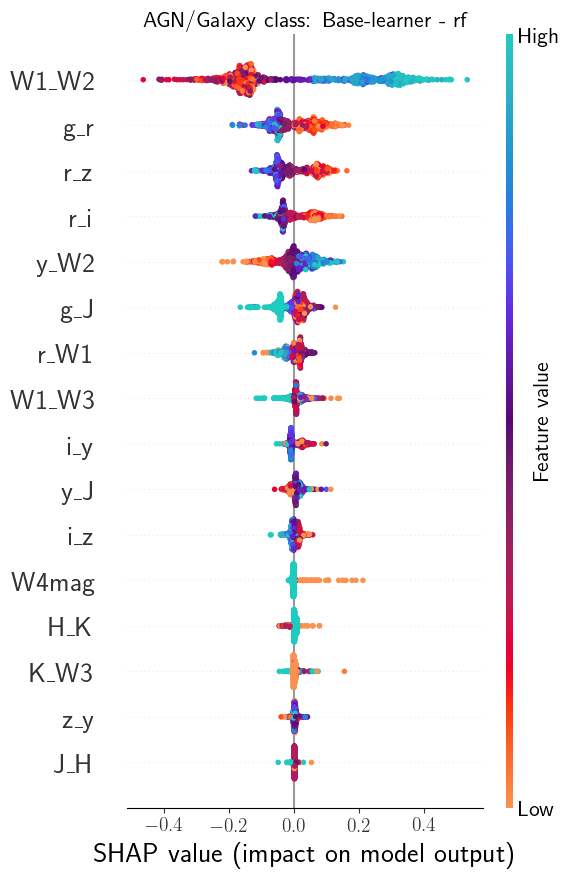

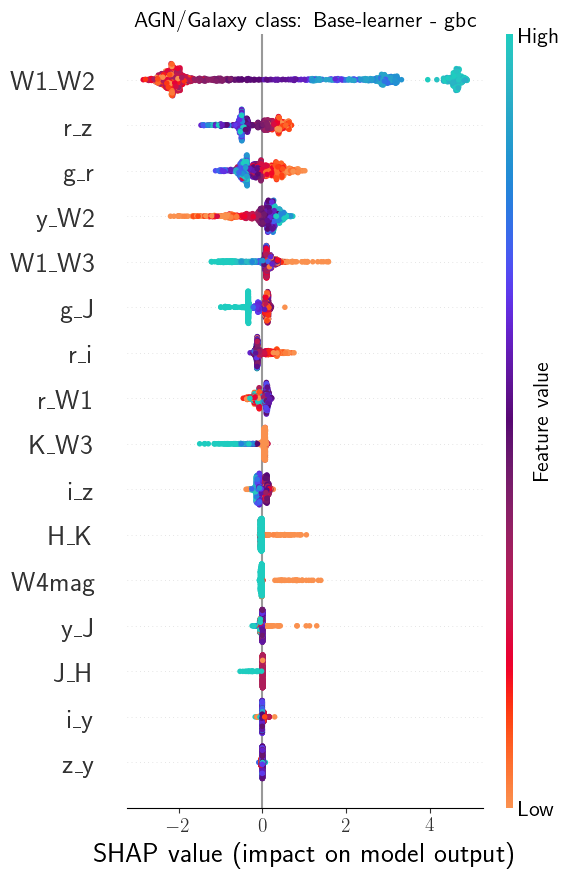

In [35]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        gf.plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [36]:
new_base_logit_AGN = np.log(gv.cal_AGN_thresh / (1 - gv.cal_AGN_thresh))

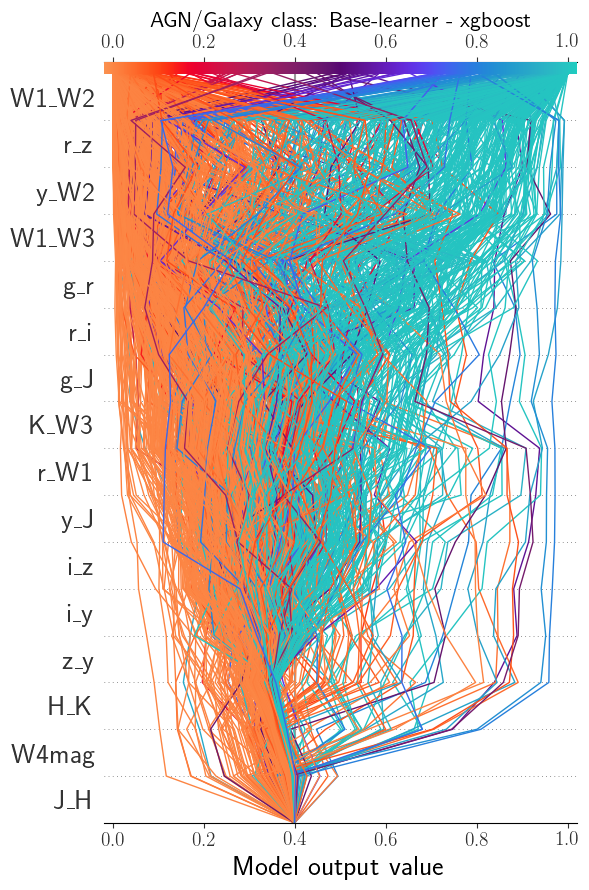

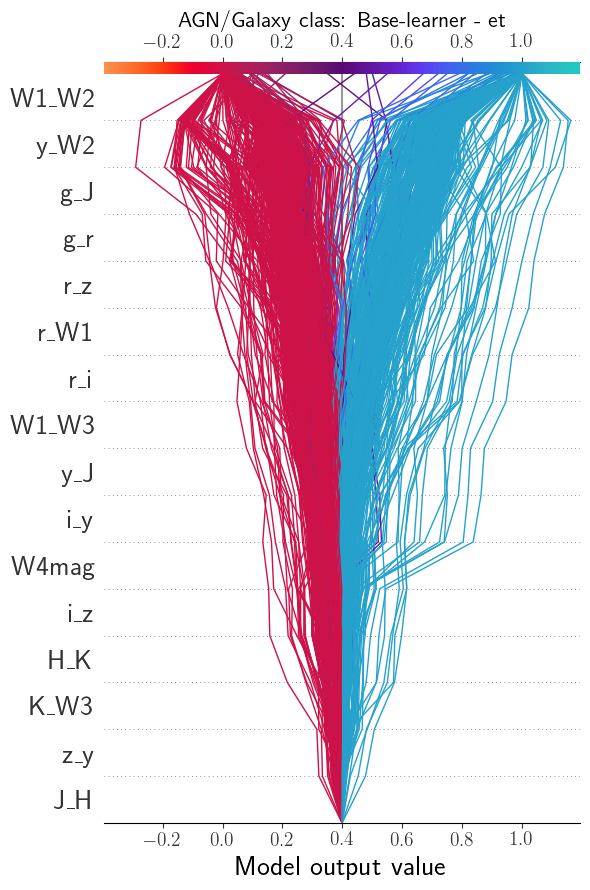

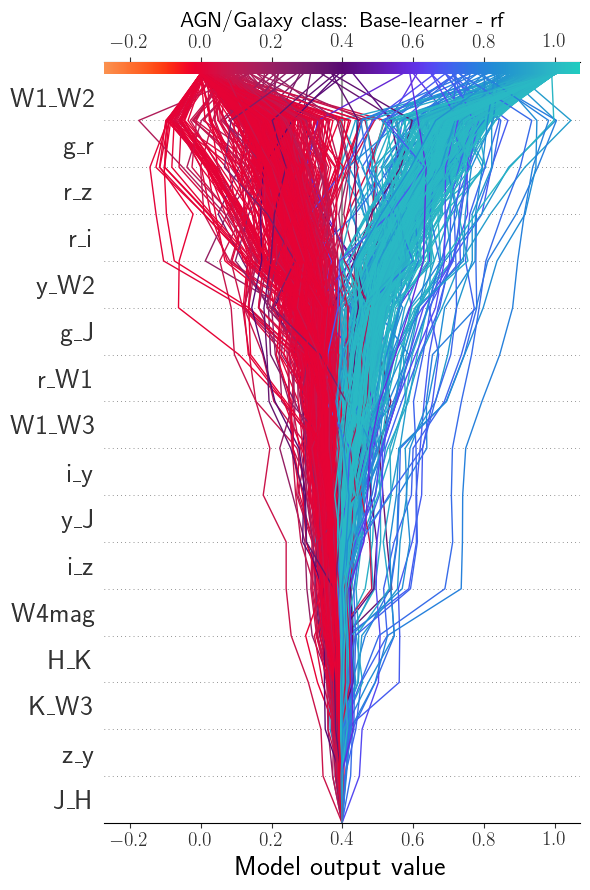

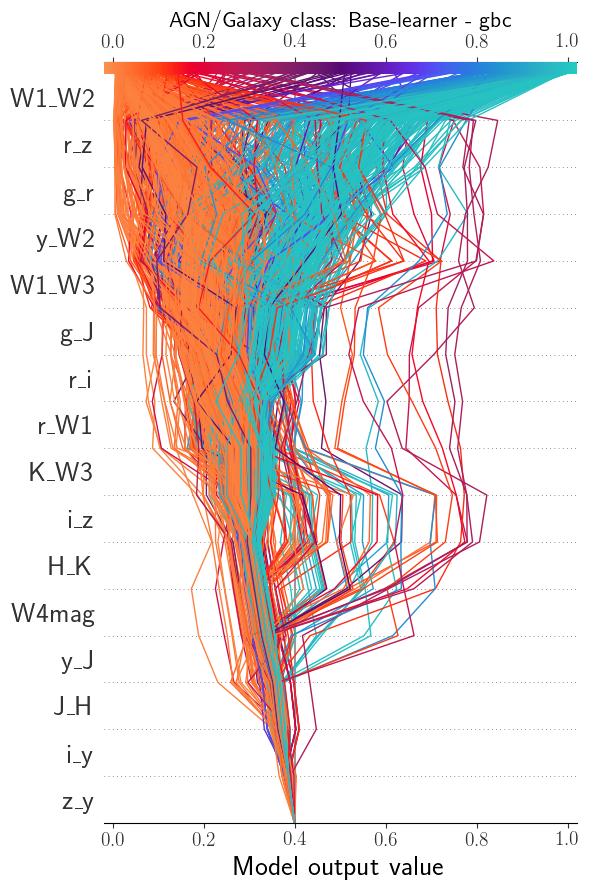

In [37]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side        = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode   = 'logit'
            new_base_AGN = new_base_logit_AGN
        else:
            logit_mode   = 'identity'
            new_base_AGN = gv.cal_AGN_thresh
        fig              = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model],\
                           reduced_cols_AGN, ax1, logit_mode, new_base_value=new_base_AGN, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

xgboost


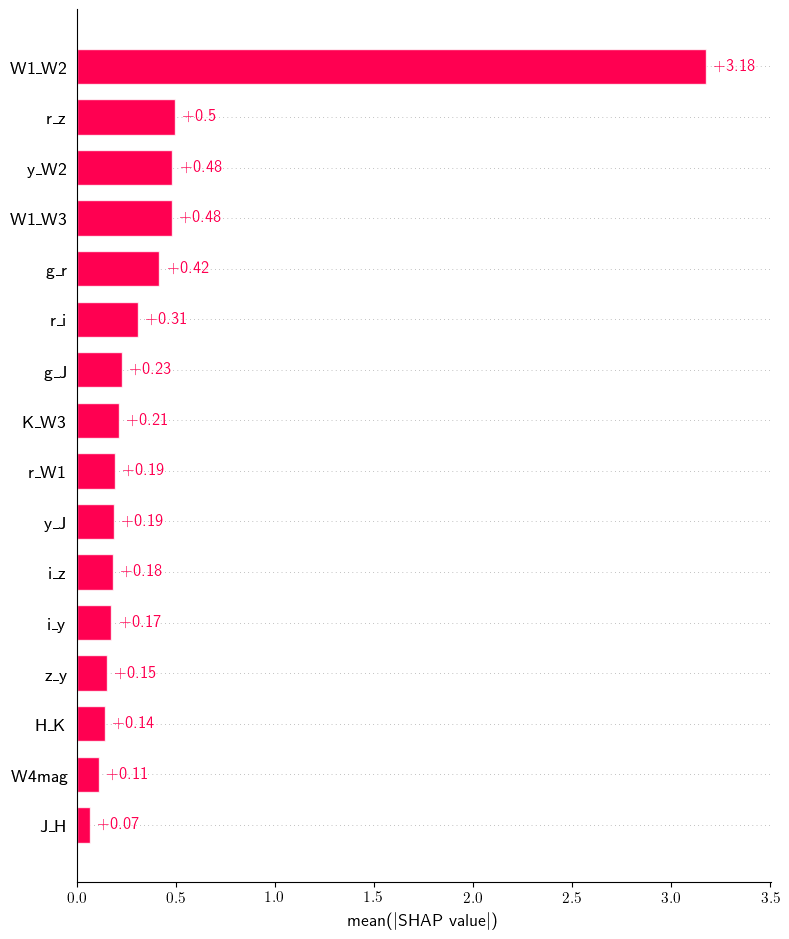

et


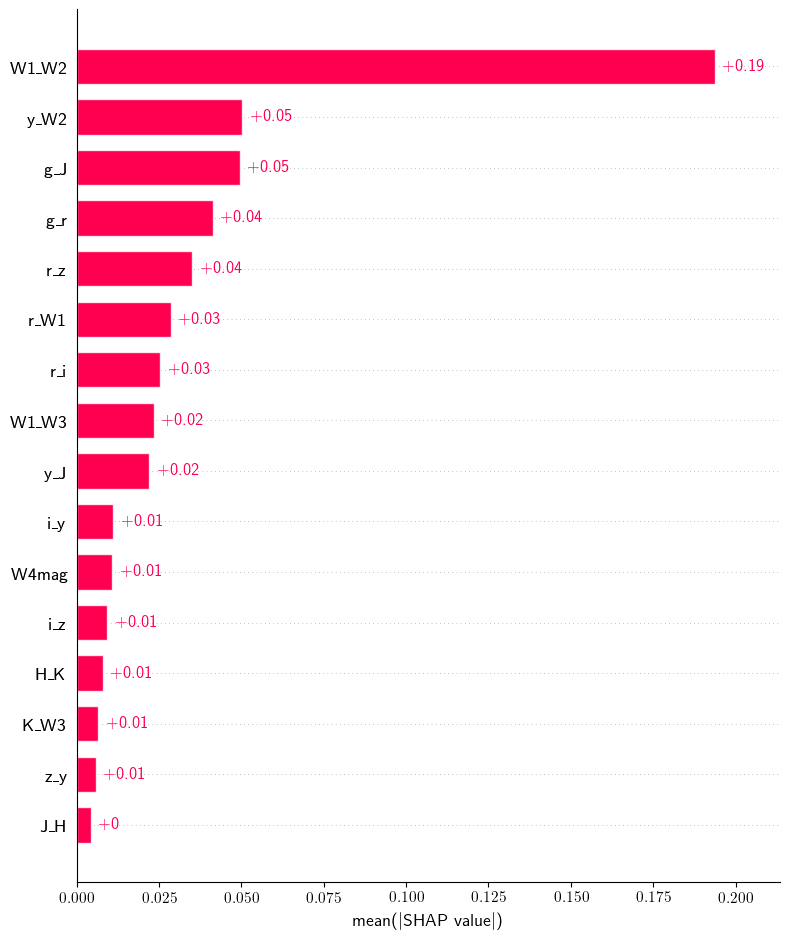

rf


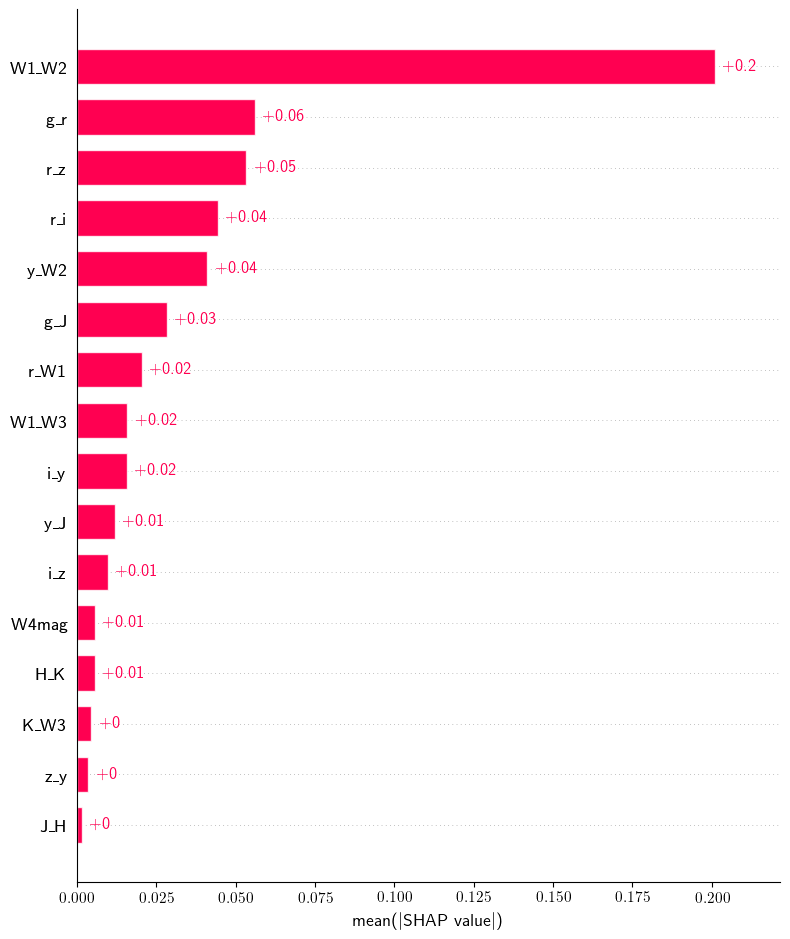

gbc


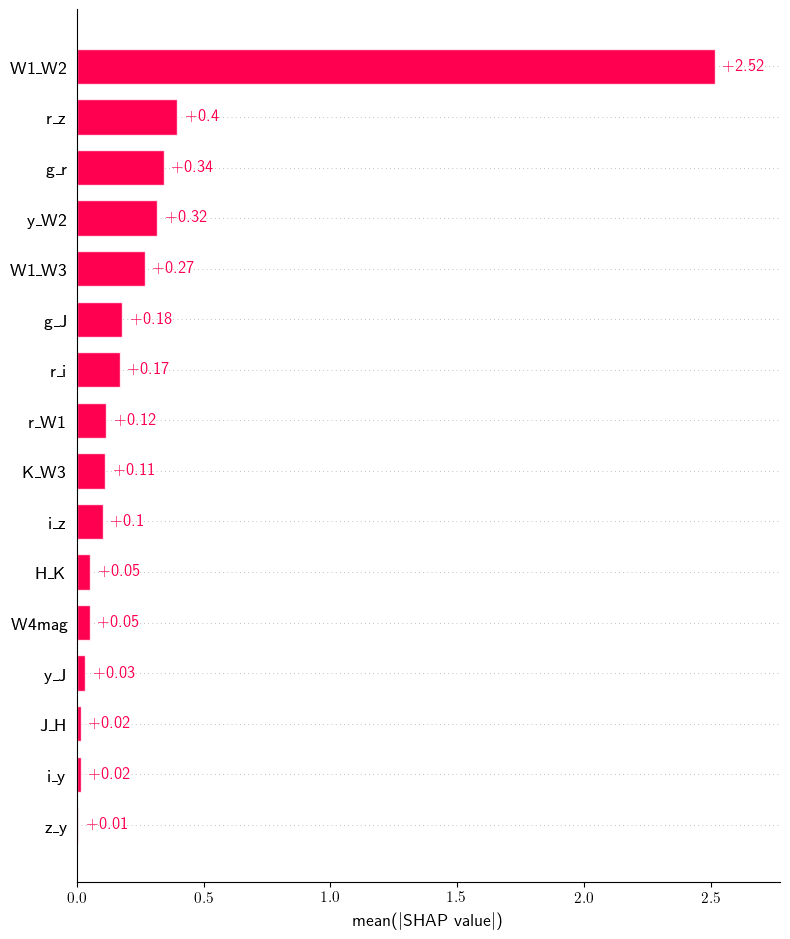

In [38]:
if run_shap_AGN_base:
    shp_copies_AGN = {}
    for model in shap_values_AGN_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_AGN[model] = shap.Explanation(values=shap_values_AGN_base[model].values,\
                                                 base_values=shap_values_AGN_base[model].base_values,\
                                                 data=shap_values_AGN_base[model].data,\
                                                 feature_names=shap_values_AGN_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model], max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


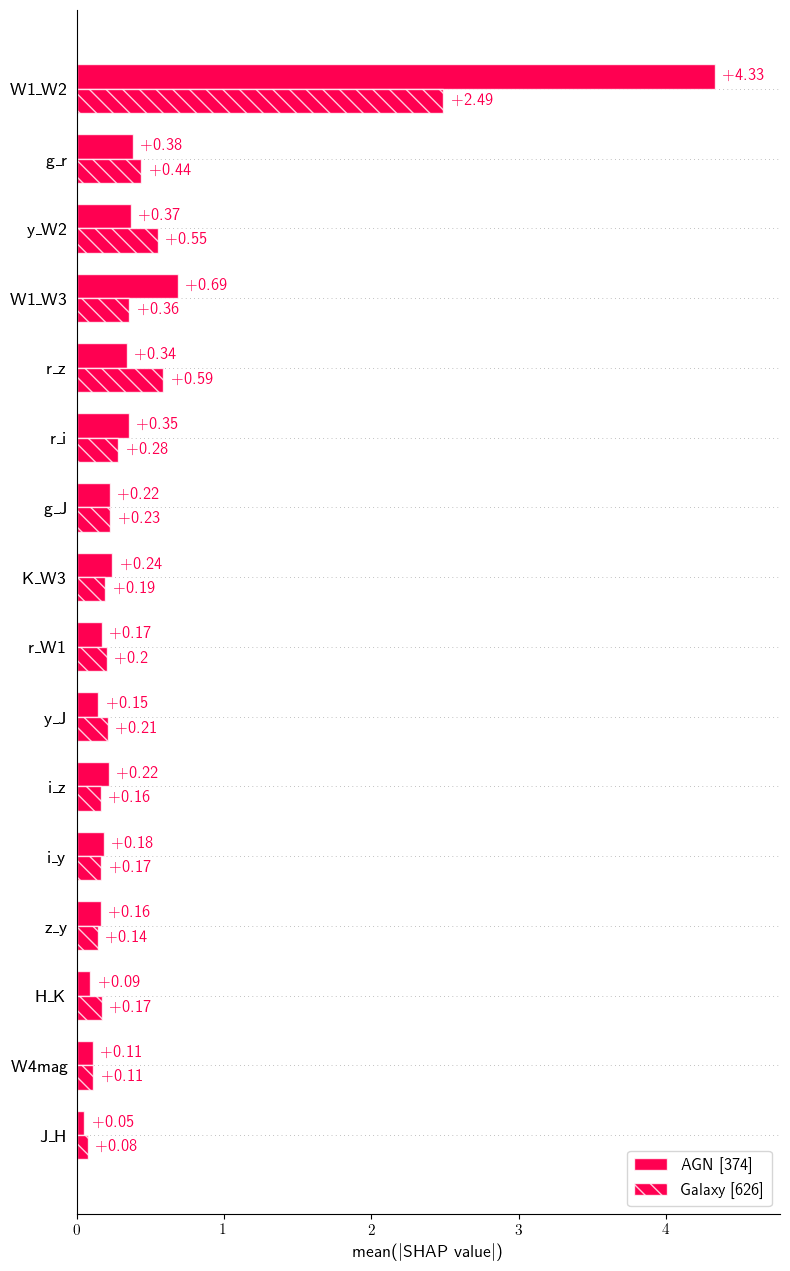

et


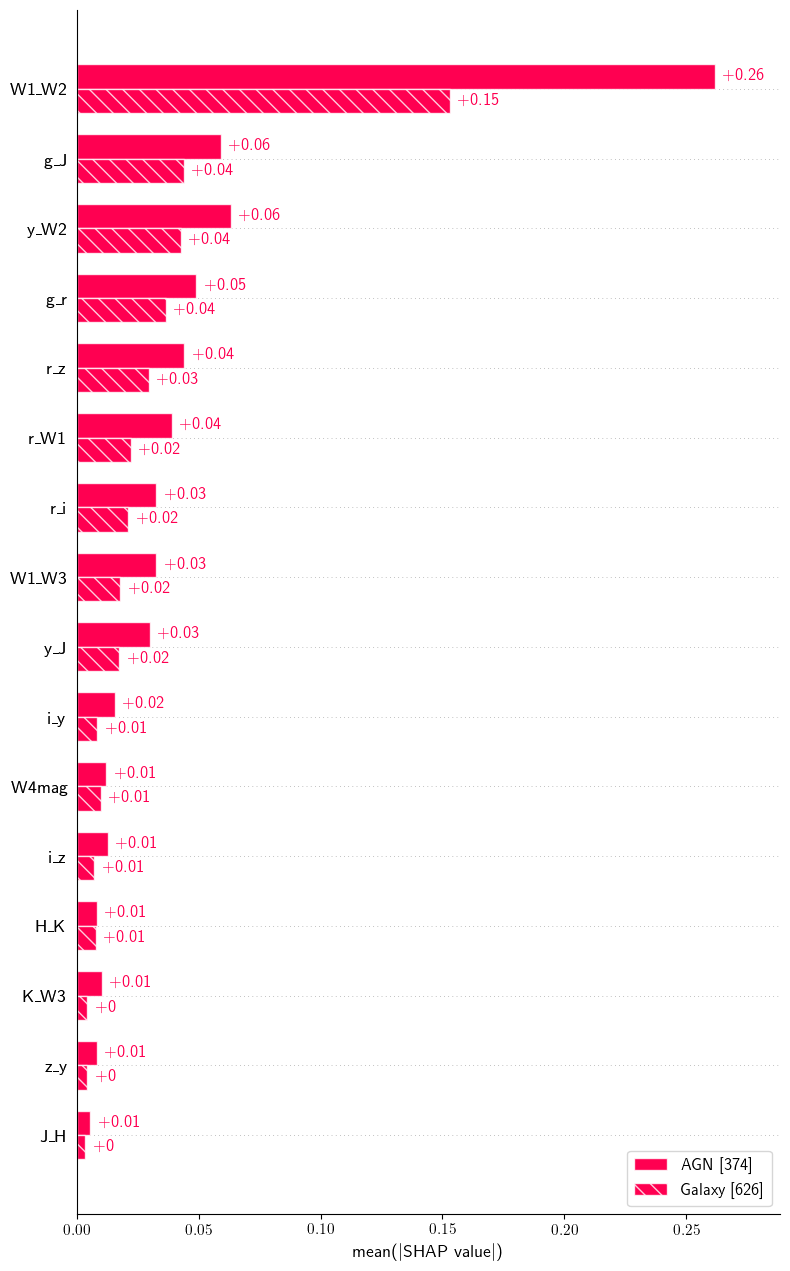

rf


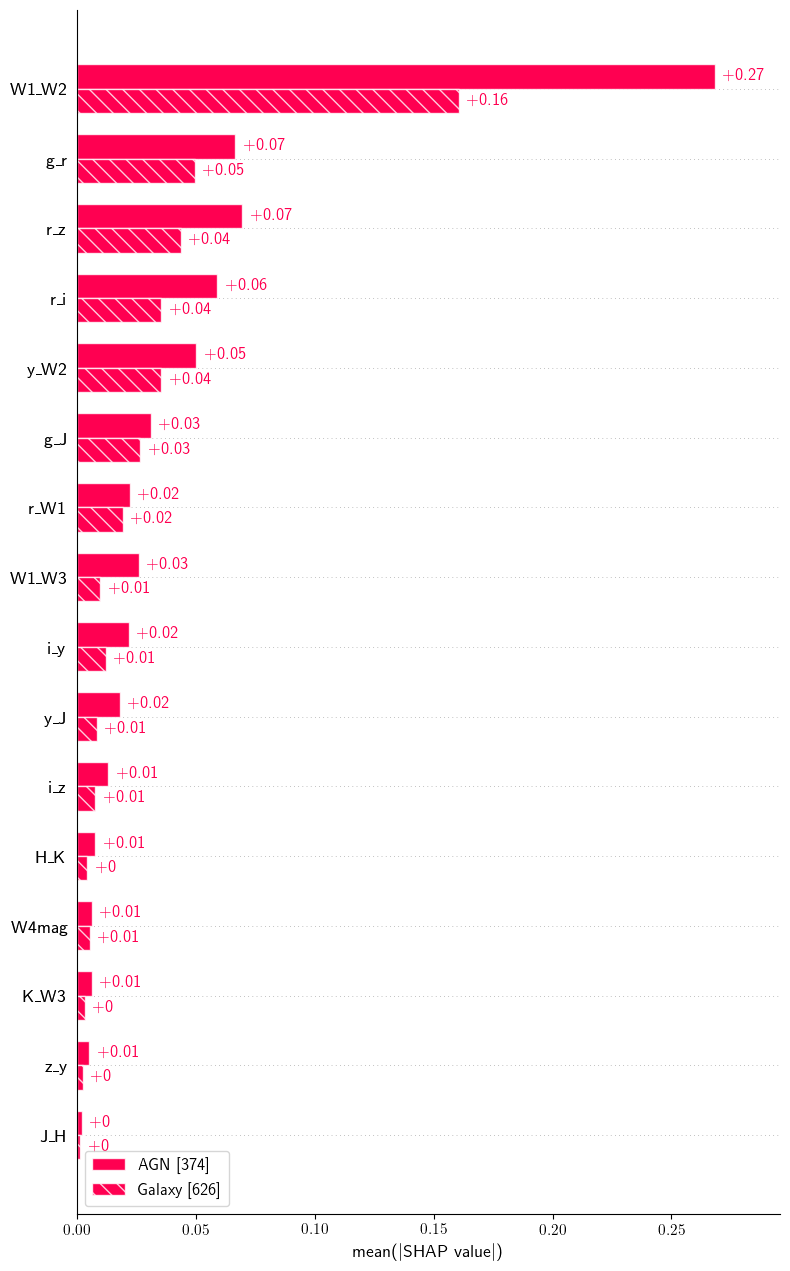

gbc


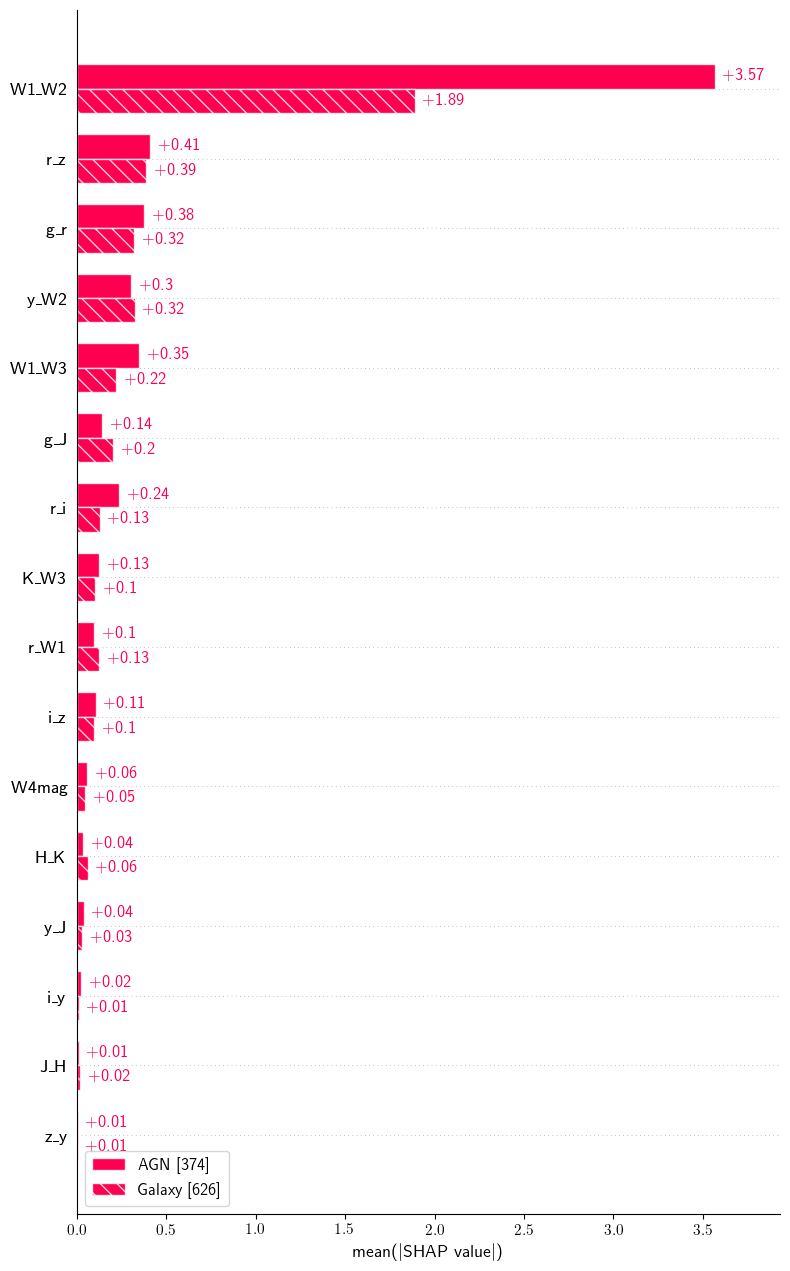

In [39]:
if run_shap_AGN_base:
    class_AGN_labels = ['Galaxy' if elem == 0 else 'AGN' for elem in reduced_data_AGN.loc[:, 'class']]
    for model in shap_values_AGN_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_AGN[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_AGN[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_AGN[model][:, :, 1].cohorts(class_AGN_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [40]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=base_models_names_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


xgboost:
0
-6.15348

et:
0
0.33872

rf:
0
0.33878

gbc:
0
-3.15989


---

#### SHAP - Radio detection model

In [41]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [42]:
if run_shap_radio_base:
    sample_size_radio   = 1000
    if not use_high_z_sources:
        filter_pred_AGN = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    if use_high_z_sources:
        filter_pred_AGN   = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
    sample_size_radio   = np.nanmin([sample_size_radio, np.sum(filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 1,000


In [43]:
if run_shap_radio_base:
    base_models_name_radio   = gf.get_base_estimators_names(radio_det_clf)

In [44]:
if run_shap_radio_base:
    reduced_data_radio    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_radio, random_state=gv.seed).copy()
    display(reduced_data_radio.loc[:, ['LOFAR_detect', 'pred_radio']].describe())
    reduced_data_radio_df = gf.preprocess_data(radio_det_clf, reduced_data_radio, base_models_name_radio)
    reduced_cols_radio    = reduced_data_radio_df.columns.drop(base_models_name_radio)

LOFAR_detect   pred_radio
count   1000.000000  1000.000000
mean       0.289000     0.287000
std        0.453525     0.452588
min        0.000000     0.000000
25%        0.000000     0.000000
50%        0.000000     0.000000
75%        1.000000     1.000000
max        1.000000     1.000000

Use FastTreeSHAP package

In [45]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                     n_jobs=12)

In [46]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=base_models_name_radio))

Working with base model xgboost
Working with base model rf
Working with base model et
Working with base model gbc


In [47]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        print(f'{model: <10}\t: {np.array([explainers_radio_base[model].expected_value]).flatten()[-1]: .4f}')

Expected "logit" values per base model
------------------------------
xgboost   	: -0.9927
rf        	:  0.2990
et        	:  0.2992
gbc       	: -1.0439


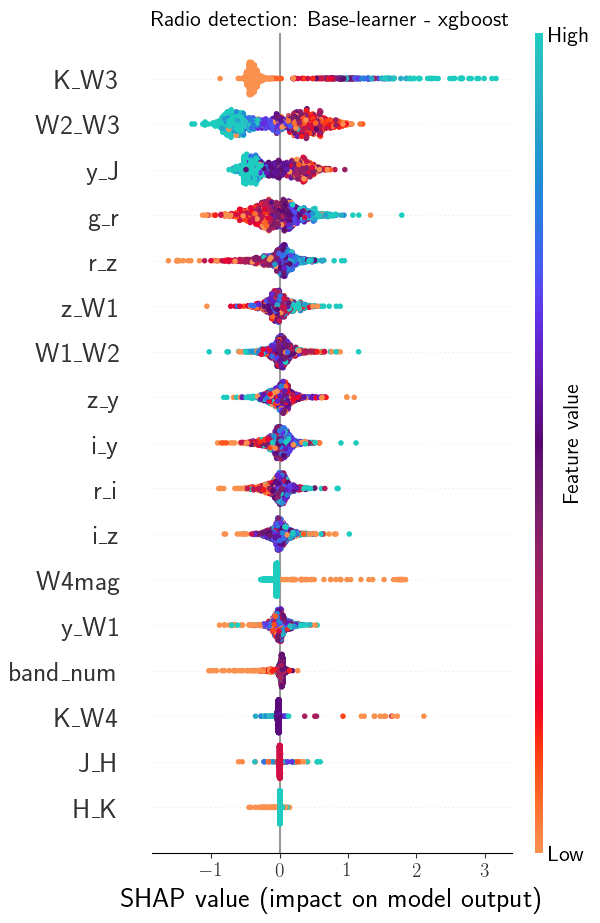

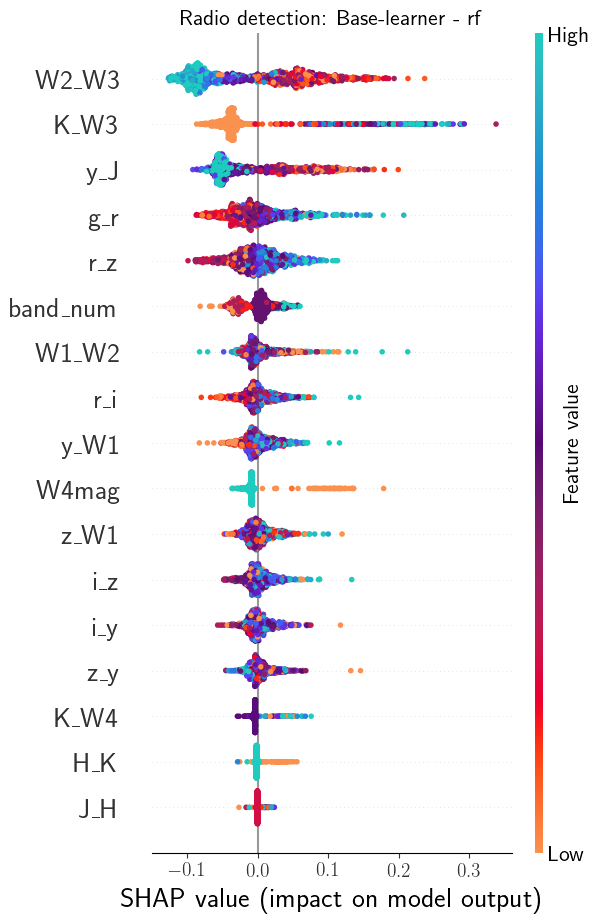

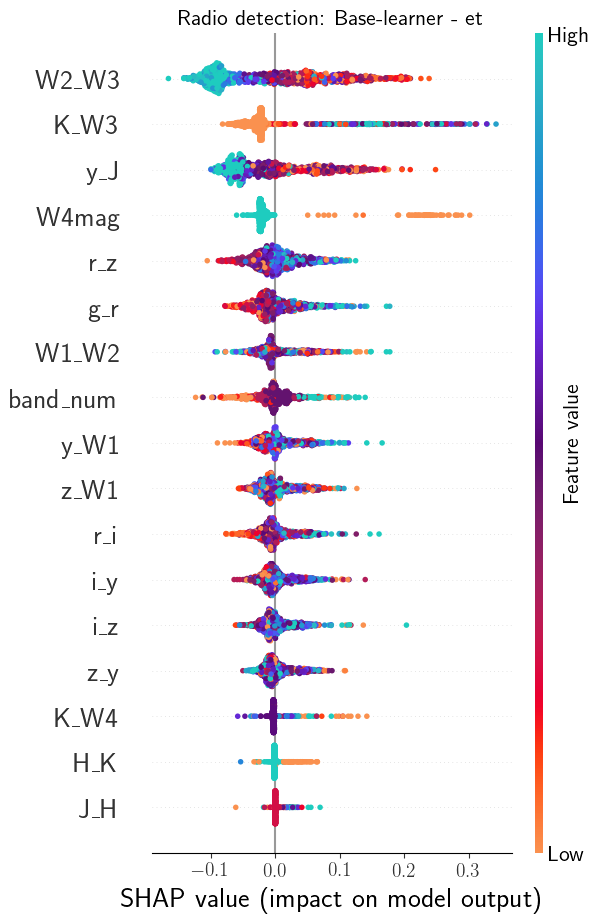

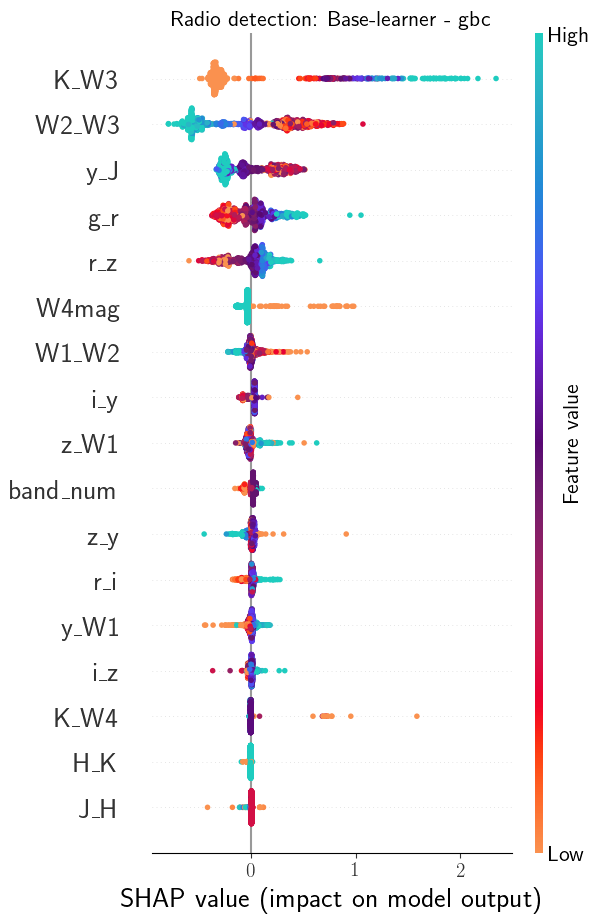

In [48]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        gf.plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [49]:
new_base_logit_radio = np.log(gv.radio_thresh / (1 - gv.radio_thresh))

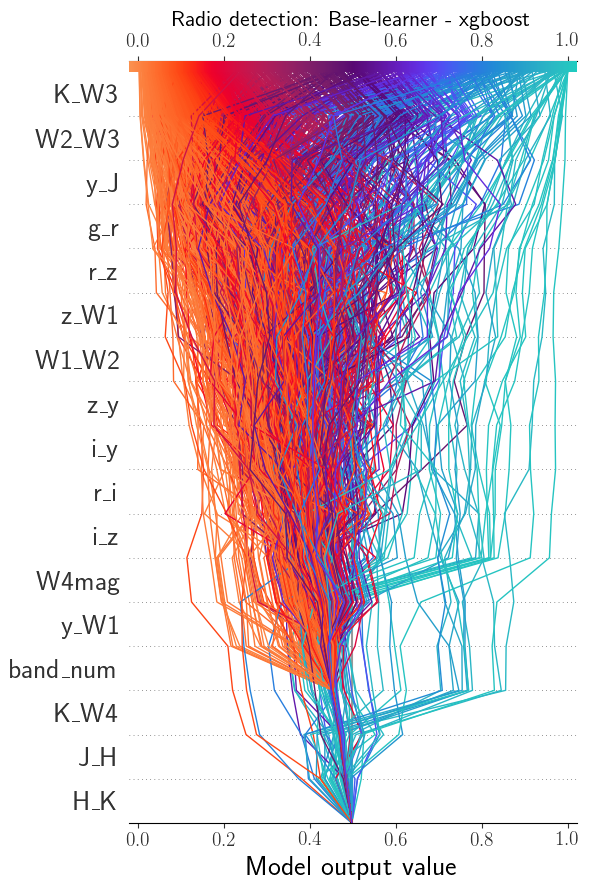

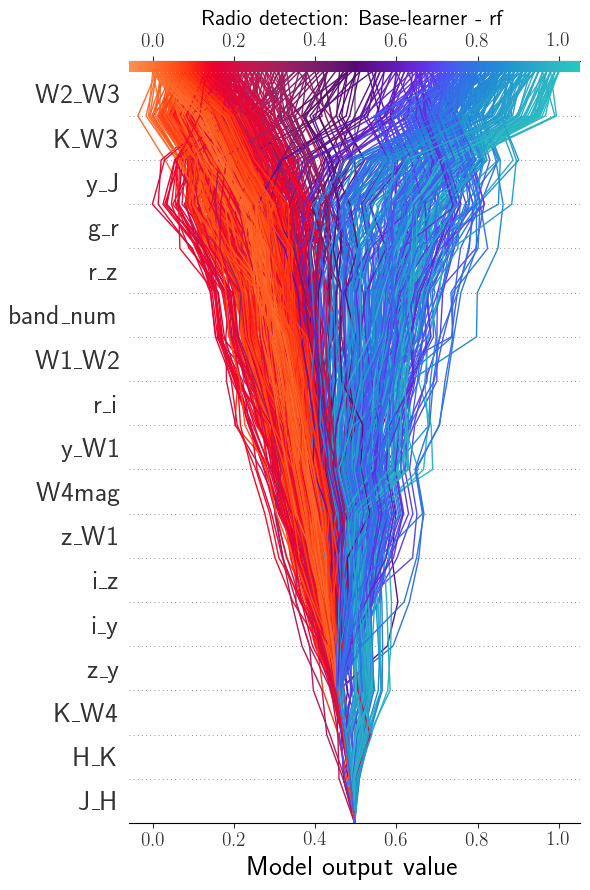

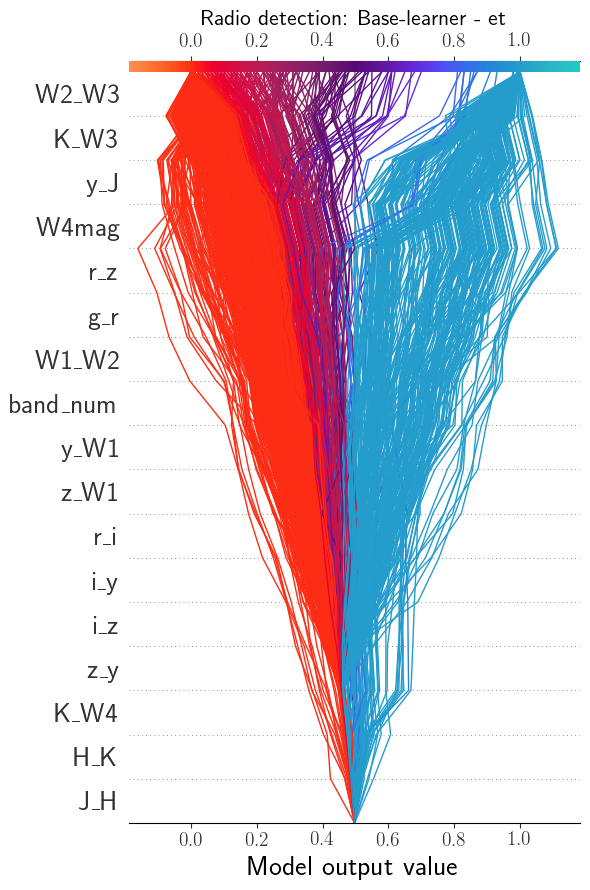

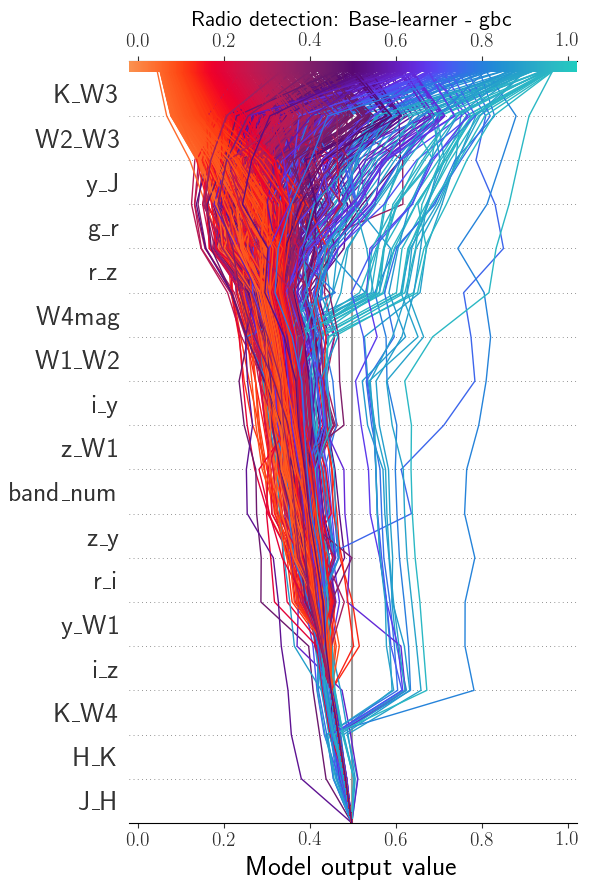

In [50]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side          = 6
        if model in ['lightgbm', 'xgboost', 'catboost', 'gbc']:
            logit_mode     = 'logit'
            new_base_radio = new_base_logit_radio
        else:
            logit_mode     = 'identity'
            new_base_radio = gv.radio_thresh
        fig                = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model],\
                                  reduced_cols_radio, ax1, logit_mode, new_base_value=new_base_radio, base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

xgboost


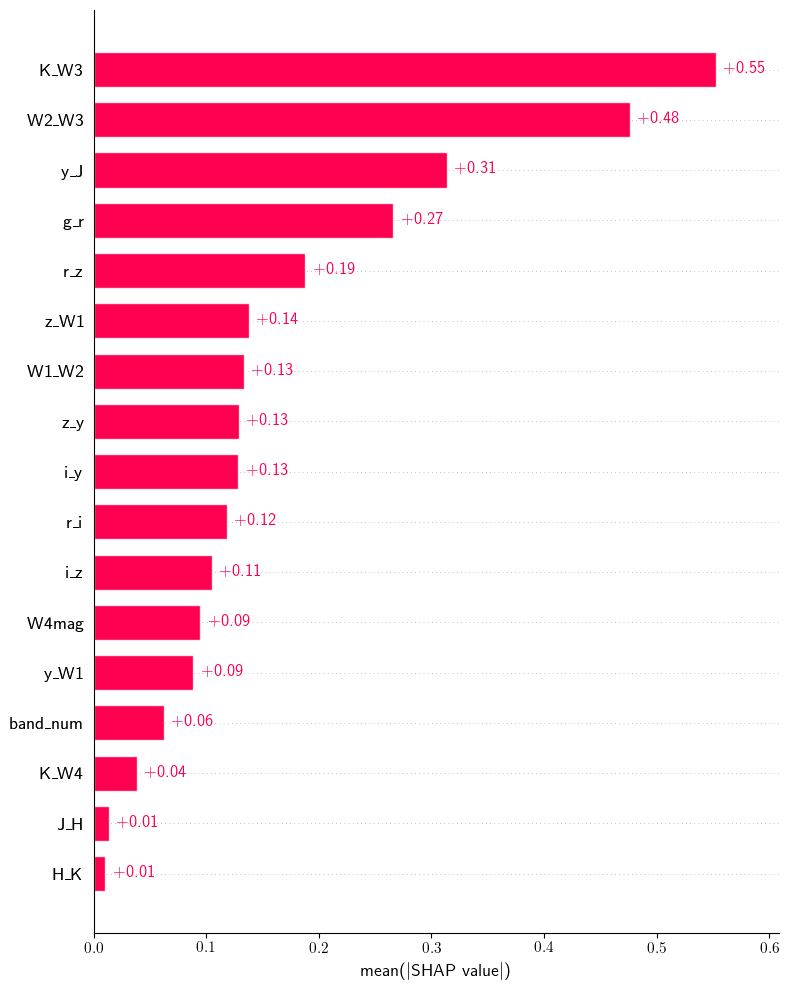

rf


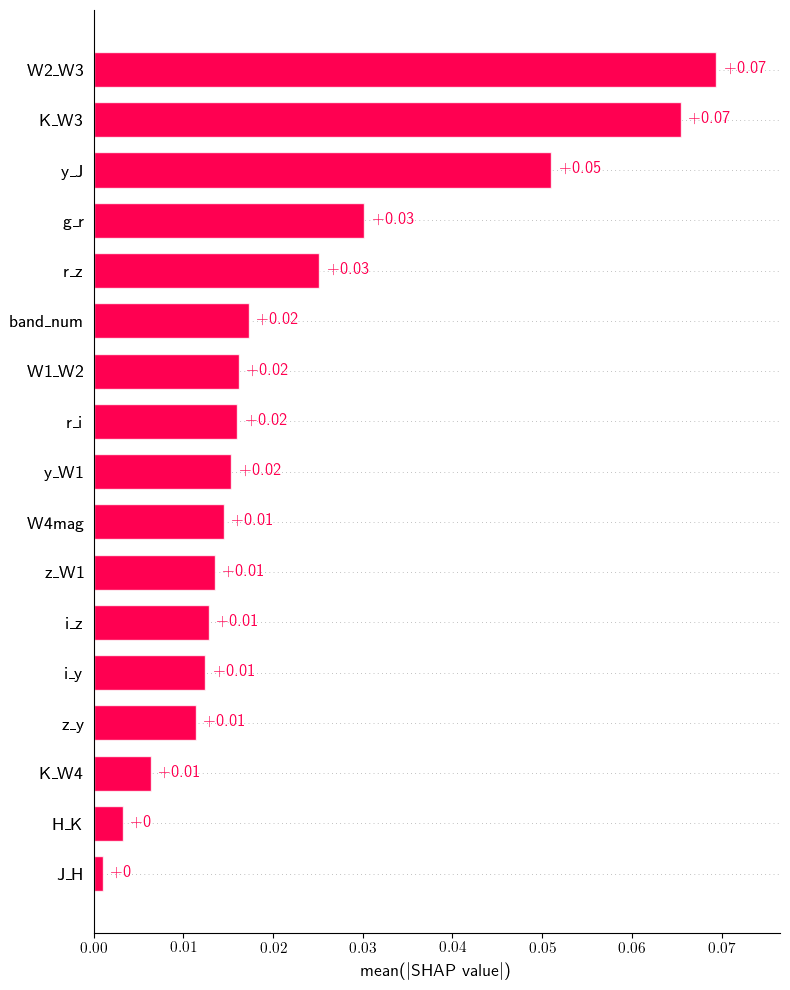

et


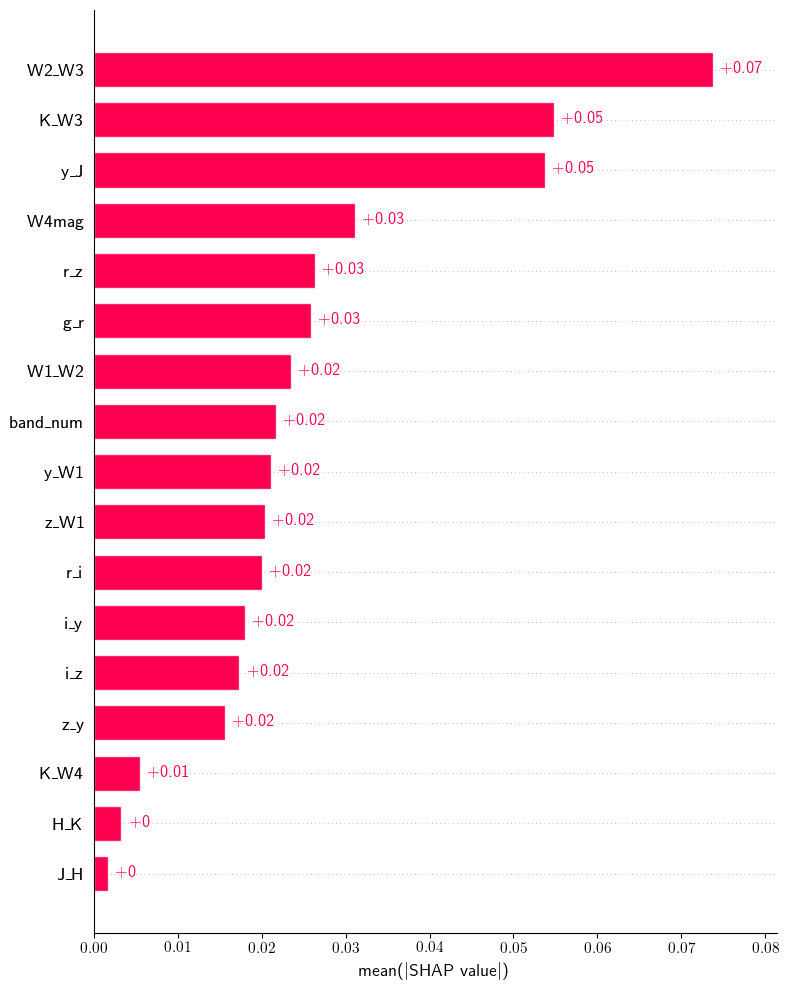

gbc


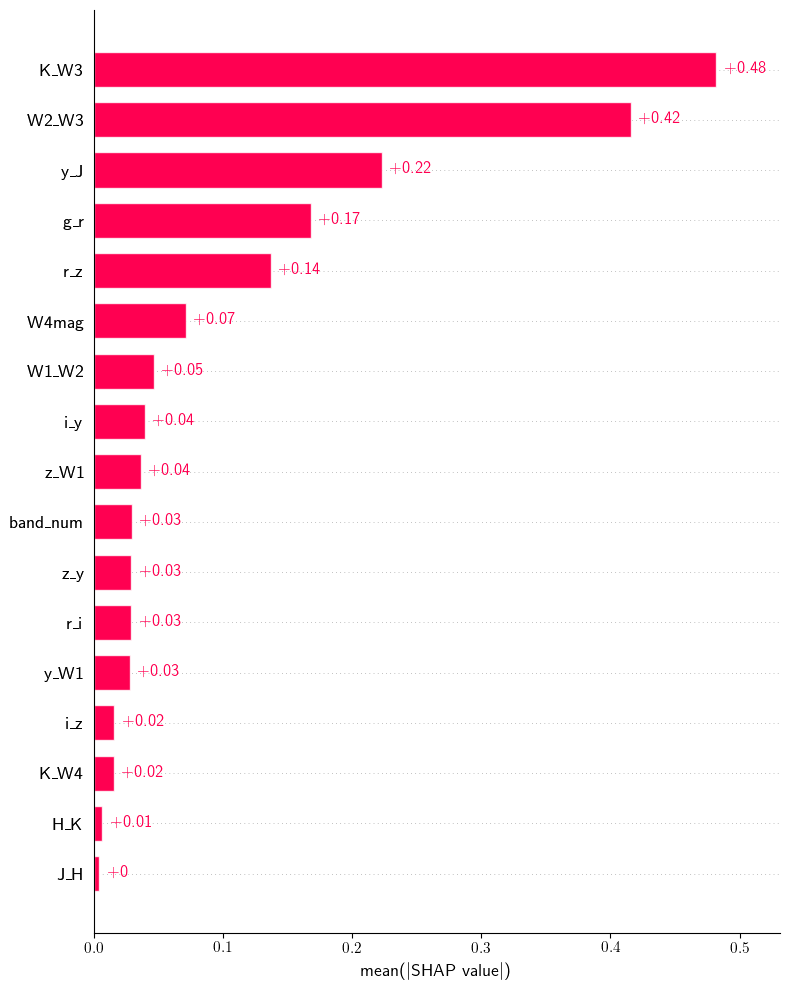

In [51]:
if run_shap_radio_base:
    shp_copies_radio = {}
    for model in shap_values_radio_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_radio[model] = shap.Explanation(values=shap_values_radio_base[model].values,\
                                                 base_values=shap_values_radio_base[model].base_values,\
                                                 data=shap_values_radio_base[model].data,\
                                                 feature_names=shap_values_radio_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model], max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

xgboost


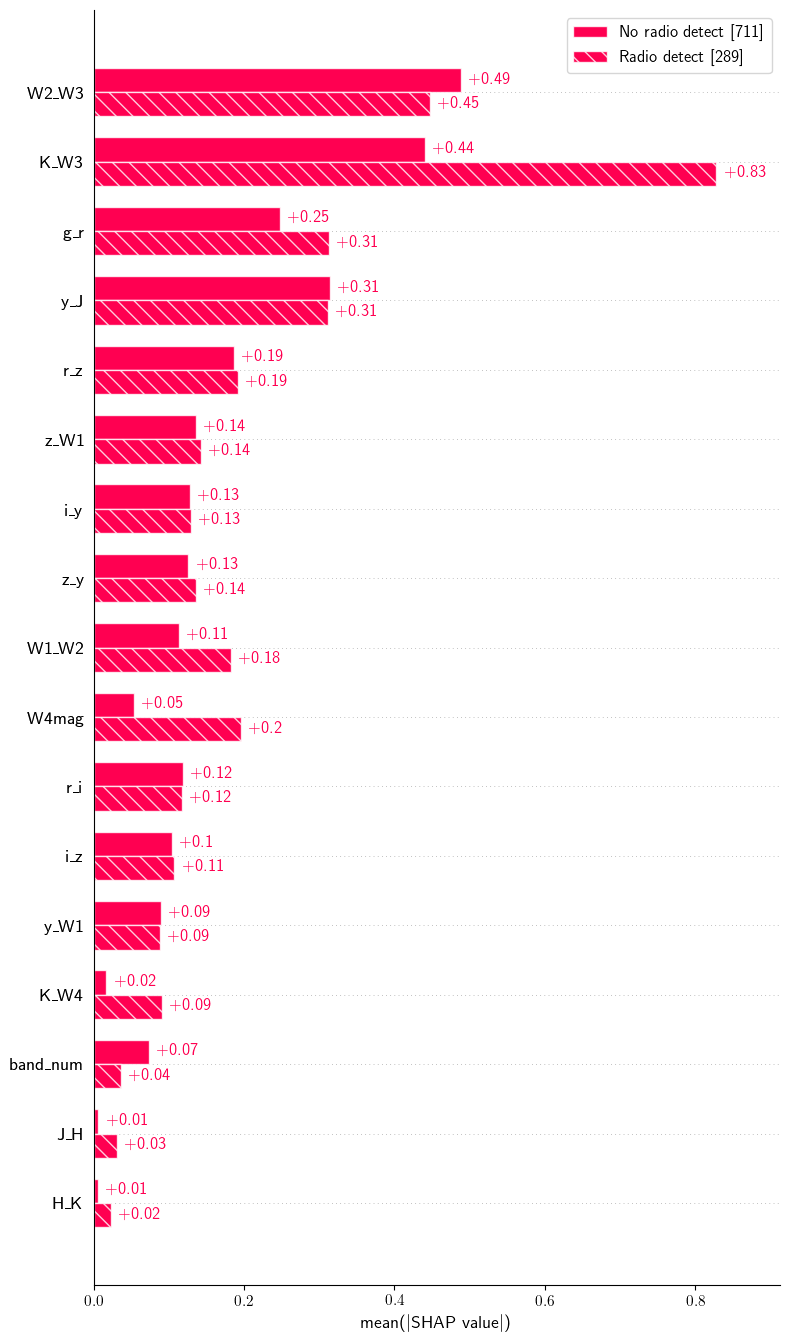

rf


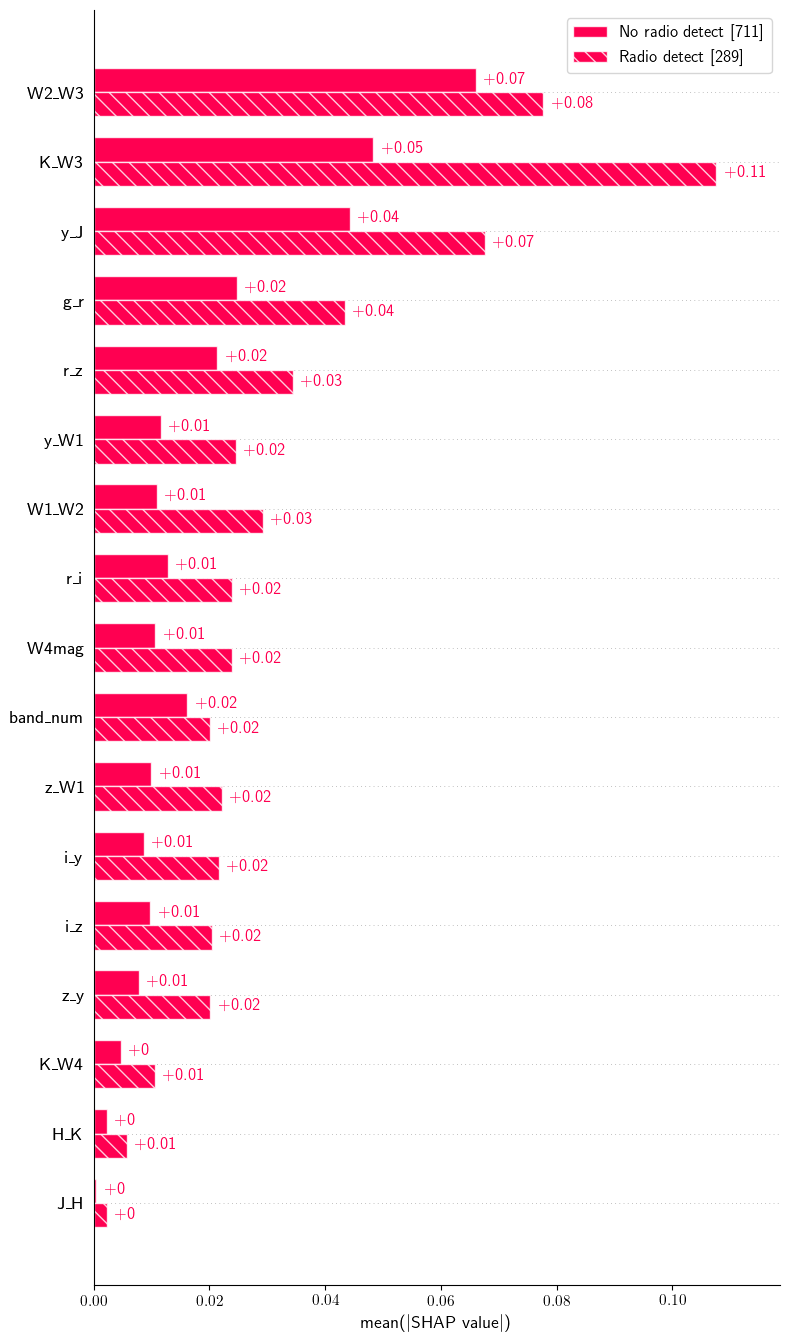

et


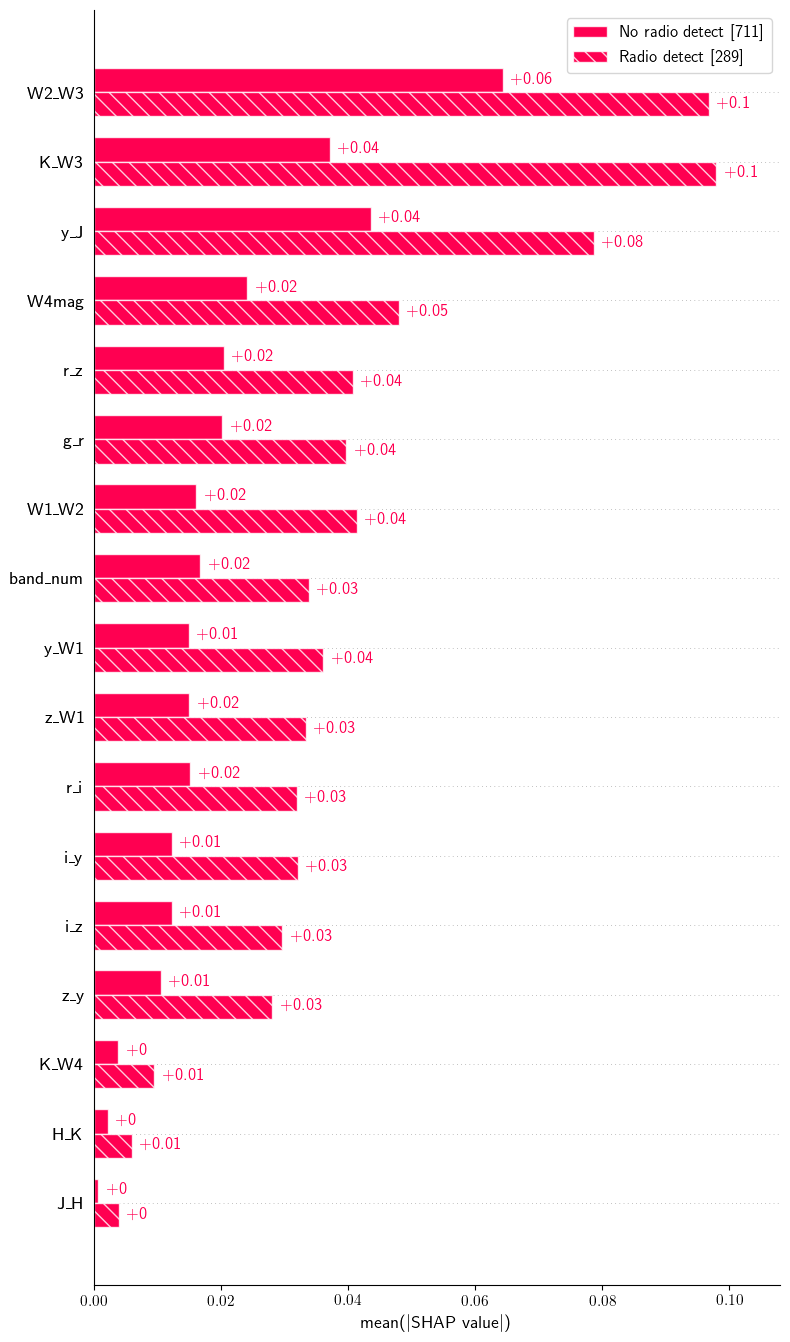

gbc


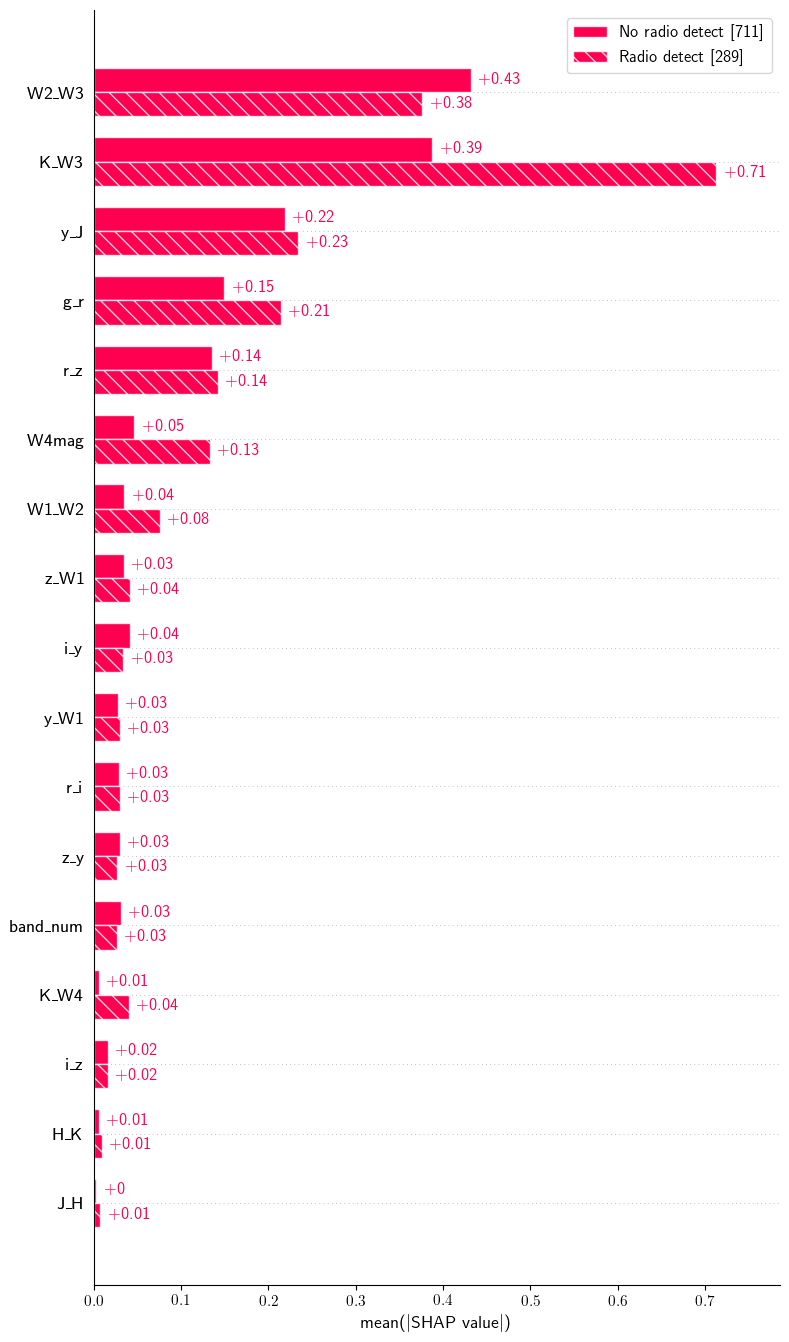

In [52]:
if run_shap_radio_base:
    radio_labels = ['No radio detect' if elem == 0 else 'Radio detect' for elem in reduced_data_radio.loc[:, 'LOFAR_detect']]
    for model in shap_values_radio_base.keys():
        print(f'{model}')
        if np.ndim(shp_copies_radio[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_radio[model].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        elif np.ndim(shp_copies_radio[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_radio[model][:, :, 1].cohorts(radio_labels).abs.mean(0), max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [53]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=base_models_name_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_radio_base[model].expected_value]).flatten()[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


xgboost:
0
-0.16179

rf:
0
0.29899

et:
0
0.29921

gbc:
1
0.26797


---

#### SHAP - First redshift prediction model

In [54]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ (or less) is a good number.

In [55]:
if run_shap_z_base:
    sample_size_z        = 1000
    if use_high_z_sources:
        filter_pred_rAGN = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 1,000


In [56]:
if run_shap_z_base:
    base_models_name_z = gf.get_base_estimators_names(redshift_reg)

In [57]:
if run_shap_z_base:
    reduced_data_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_z, random_state=gv.seed).copy()
    display(reduced_data_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_z_df = gf.preprocess_data(redshift_reg, reduced_data_z, base_models_name_z)
    reduced_cols_z    = reduced_data_z_df.columns.drop(base_models_name_z)

Z       pred_Z
count  1000.000000  1000.000000
mean      1.532507     1.741991
std       0.763186     0.750098
min       0.000000     0.031000
25%       0.971750     1.235750
50%       1.529500     1.787500
75%       2.077500     2.339250
max       4.050000     3.699000

Use FastTreeSHAP package

In [58]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                 n_jobs=12)

In [59]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=base_models_name_z))

Working with base model et
Working with base model catboost
Working with base model xgboost
Working with base model gbr


In [60]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
et        	:  1.3095
catboost  	:  1.3093
xgboost   	:  1.3095
gbr       	:  1.3095


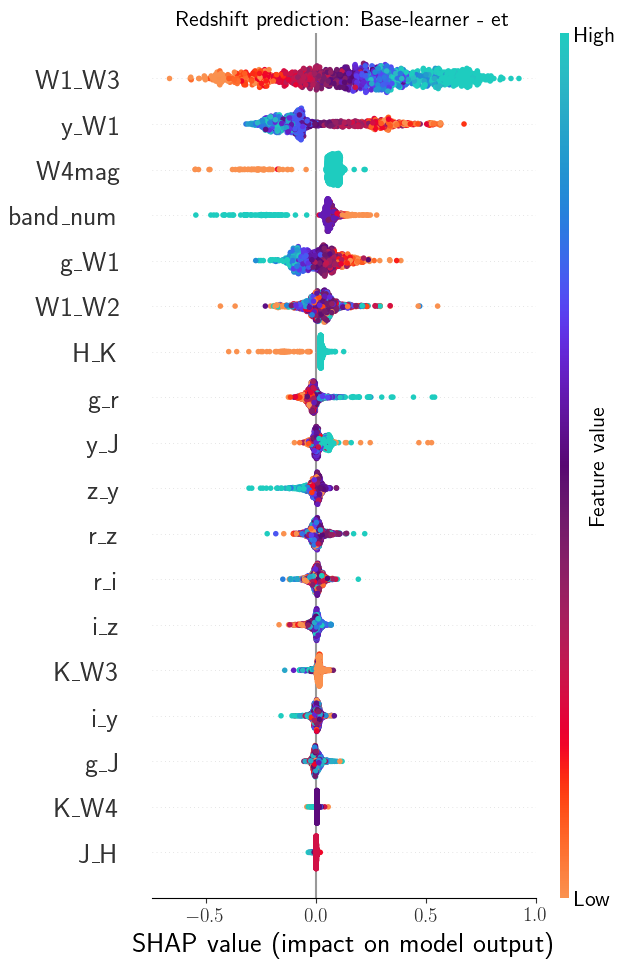

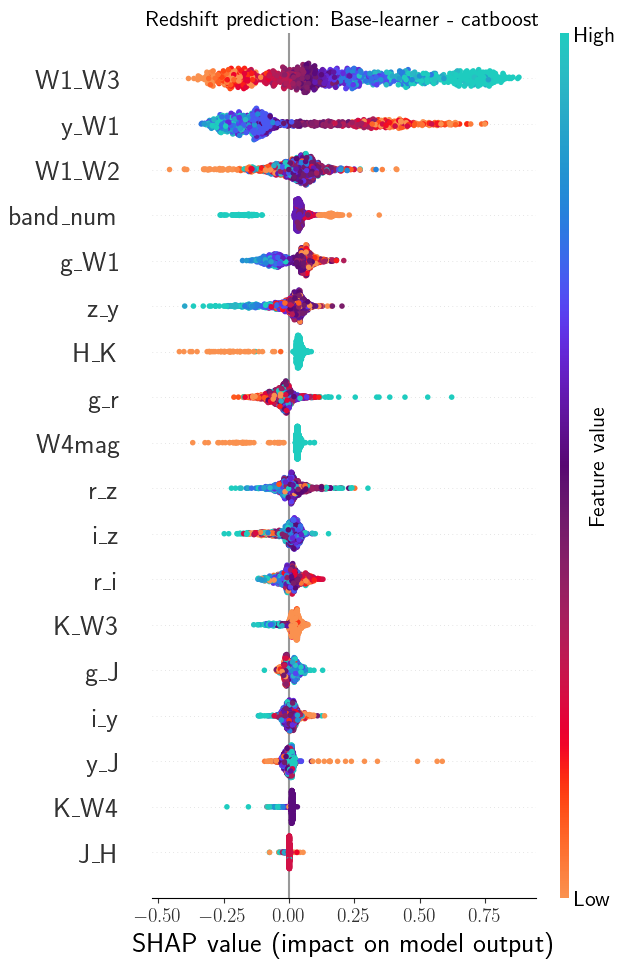

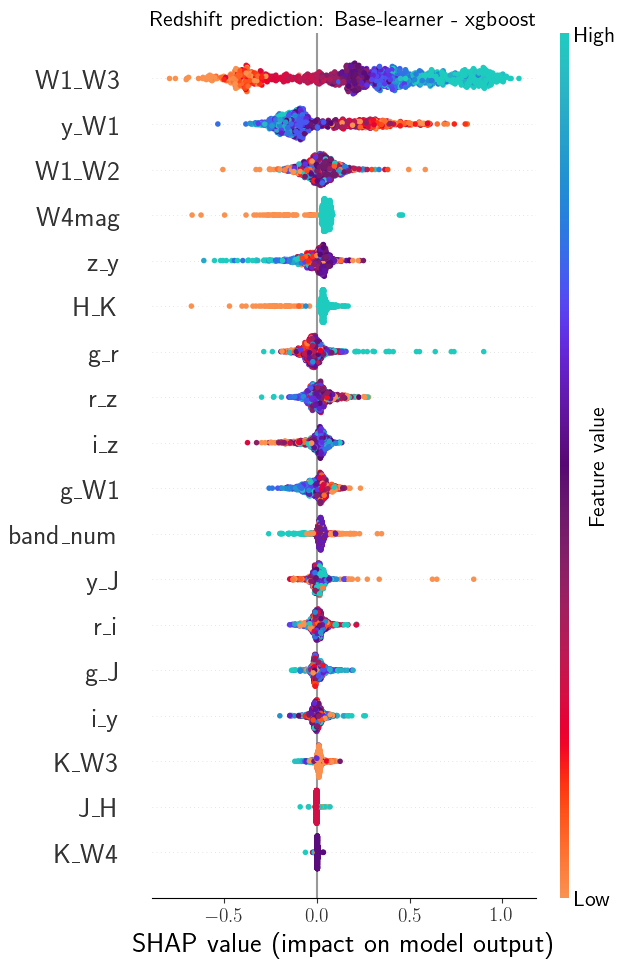

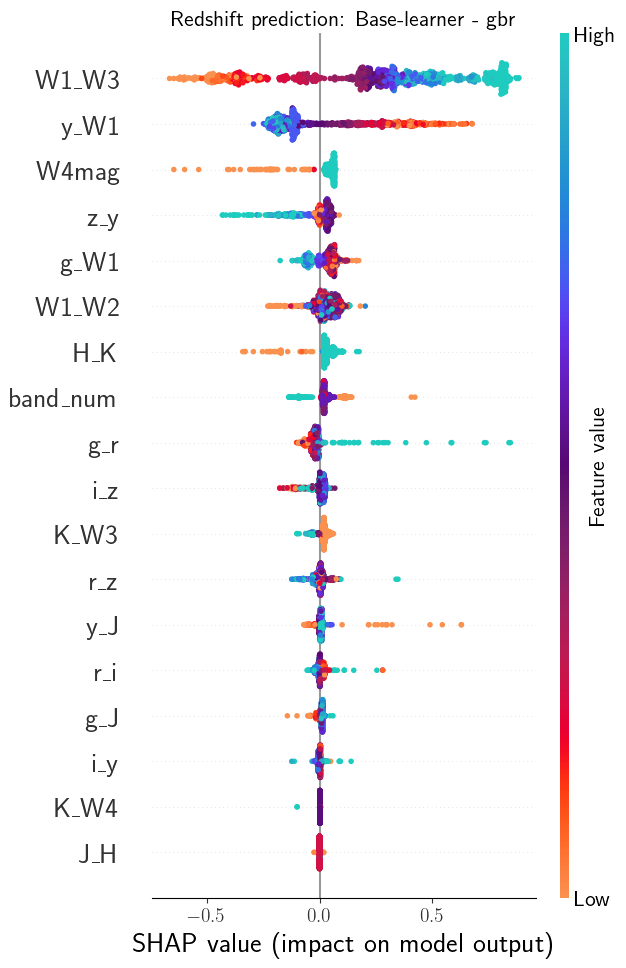

In [61]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        gf.plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

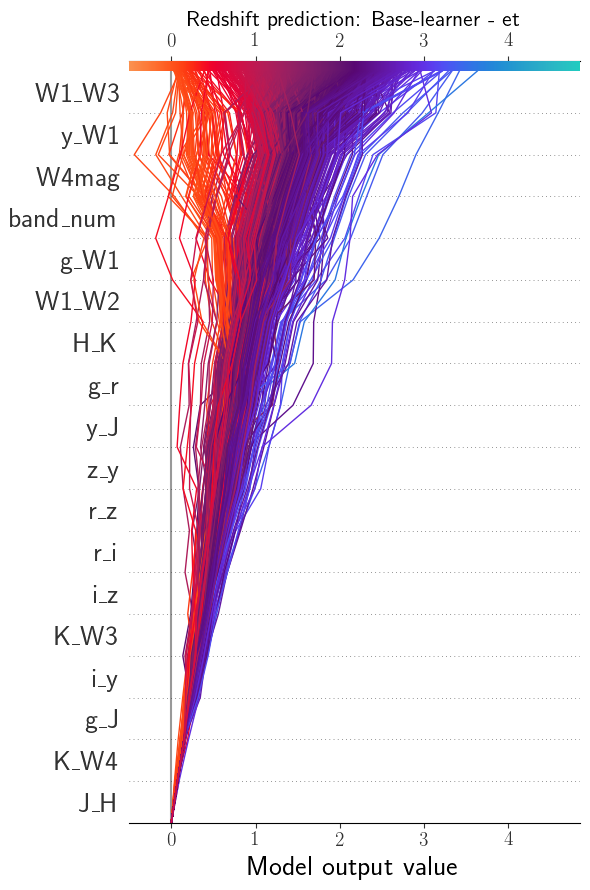

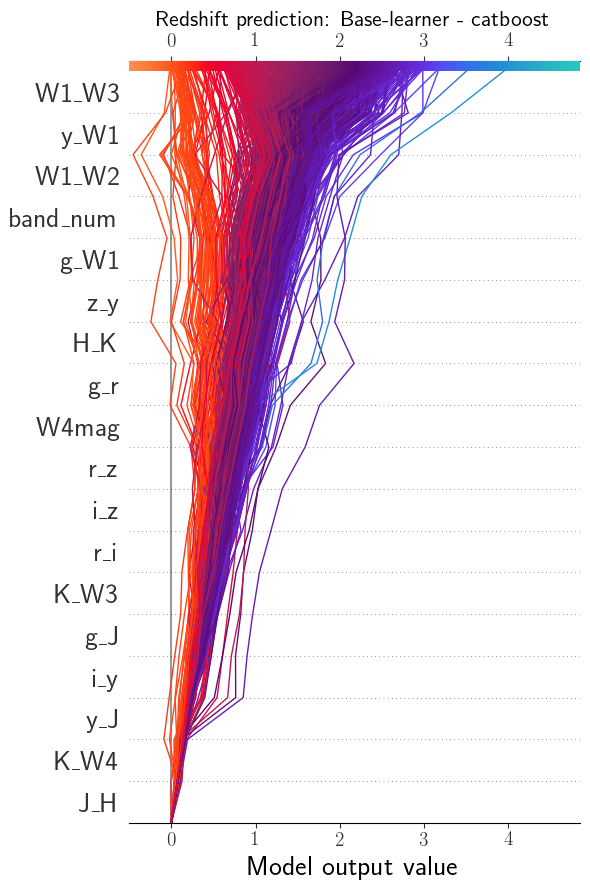

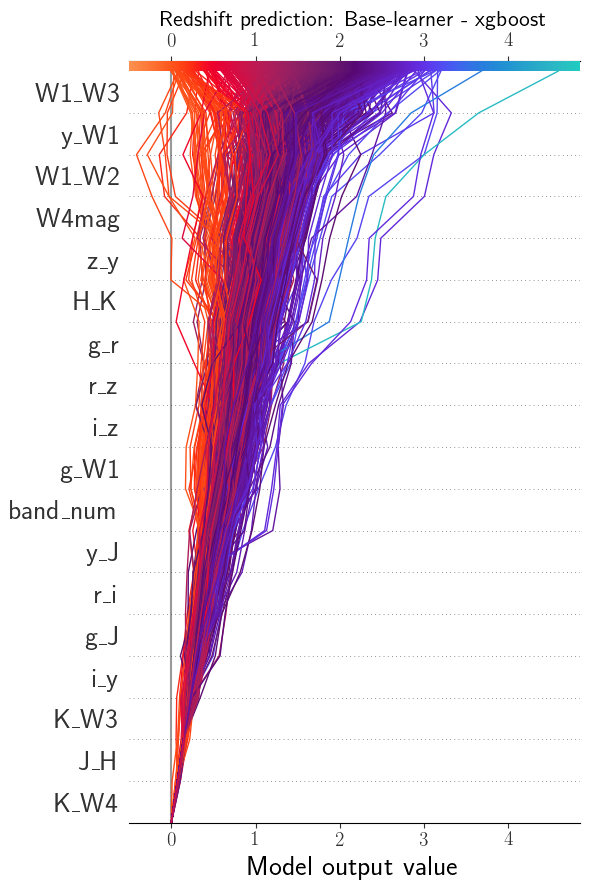

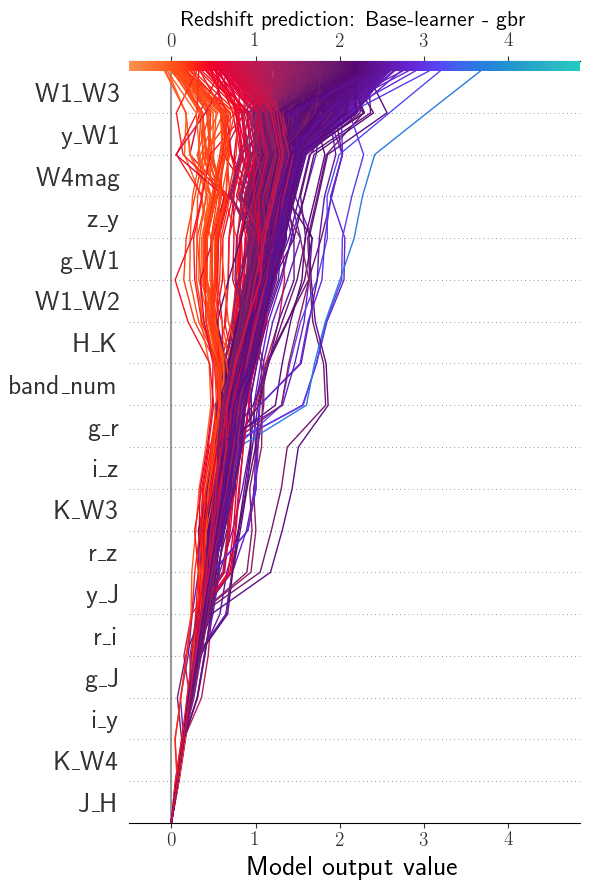

In [62]:
if run_shap_z_base:
    xlims_plt_z         = (-0.5, full_catalog_df.loc[reduced_data_z_df.index, ['Z', 'pred_Z']].max().max() + 0.8)
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model],\
                                  reduced_cols_z, ax1, 'identity', new_base_value=0.0, base_meta='Base', xlim=xlims_plt_z)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

et


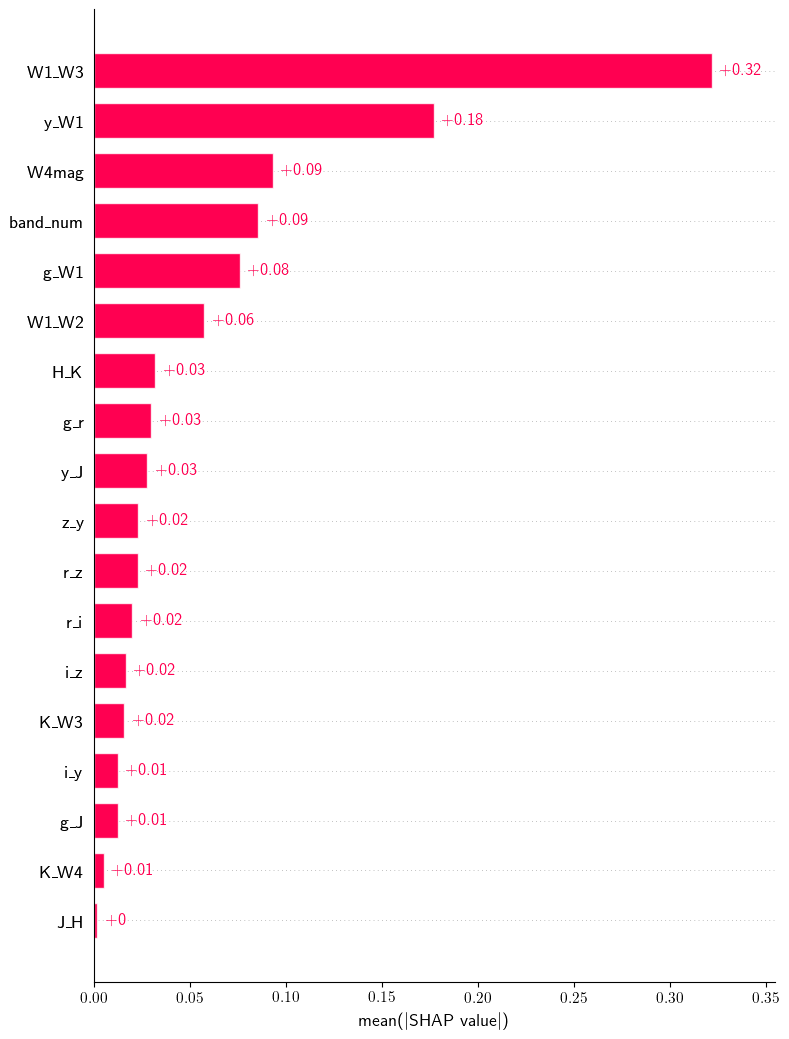

catboost


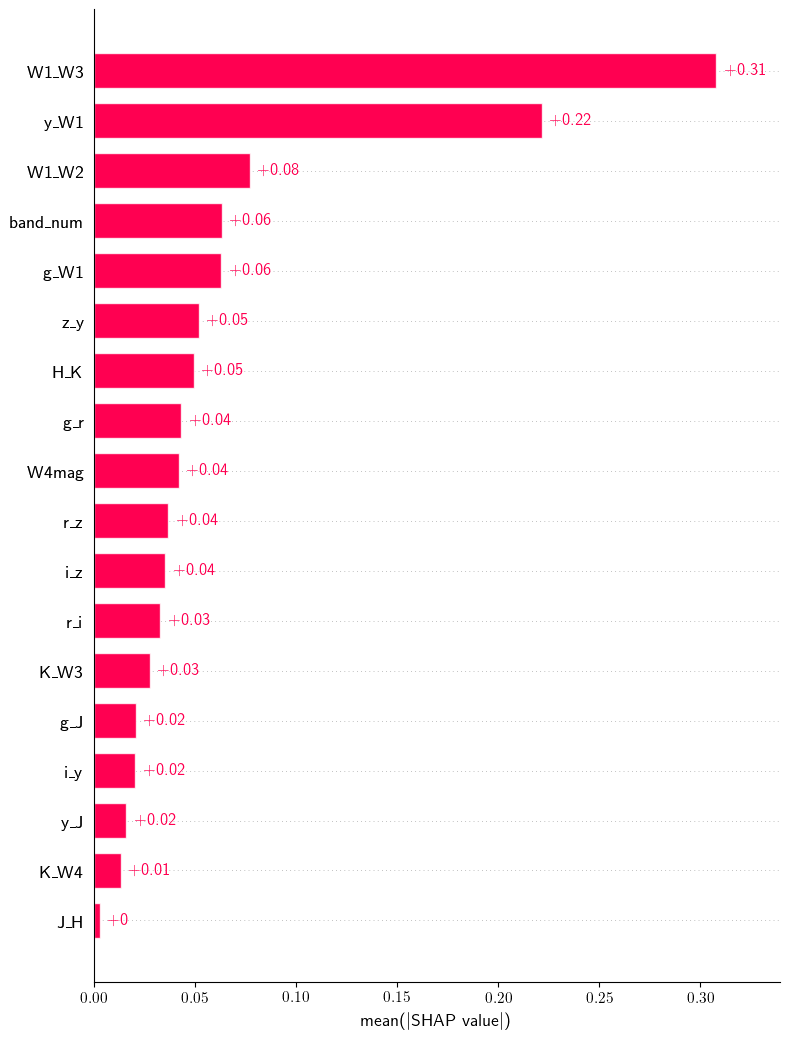

xgboost


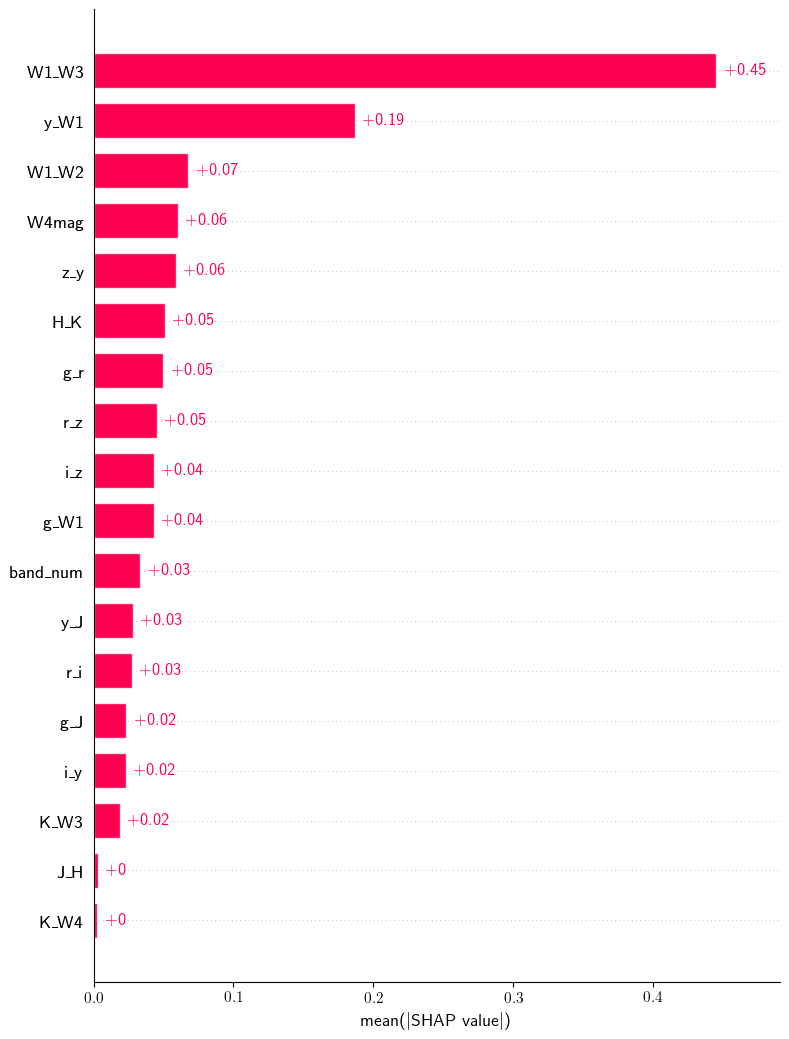

gbr


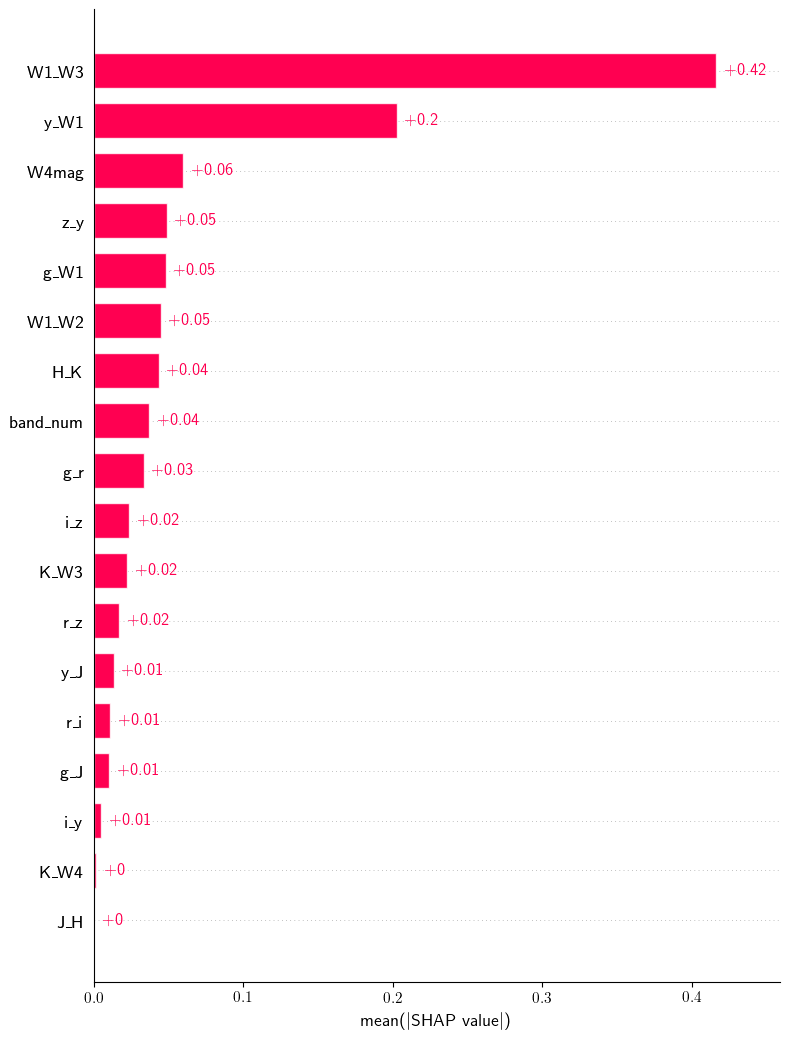

In [63]:
if run_shap_z_base:
    shp_copies_z = {}
    for model in shap_values_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_z[model] = shap.Explanation(values=shap_values_z_base[model].values,\
                                               base_values=shap_values_z_base[model].base_values,\
                                               data=shap_values_z_base[model].data,\
                                               feature_names=shap_values_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [64]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=base_models_name_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


et:
1.32729
1.32729

catboost:
1.31717
1.31717

xgboost:
1.39312
1.39312

gbr:
1.51767
1.51767


---

#### SHAP - Second redshift prediction model

In [65]:
if not use_second_z_model: run_shap_high_z_meta = False

In [66]:
if run_shap_high_z_base & use_second_z_model:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [67]:
if run_shap_high_z_base & use_second_z_model:
    sample_size_high_z          = 1000
    if use_high_z_sources:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    elif not use_high_z_sources:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol))
    sample_size_high_z          = np.nanmin([sample_size_high_z, np.sum(filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 967


In [68]:
if run_shap_high_z_base & use_second_z_model:
    base_models_name_high_z = gf.get_base_estimators_names(redshift_reg_2)

In [69]:
if run_shap_high_z_base & use_second_z_model:
    reduced_data_high_z    = full_catalog_df.loc[filter_pred_AGN].sample(n=sample_size_high_z, random_state=gv.seed).copy()
    display(reduced_data_high_z.loc[:, ['Z', 'pred_Z']].describe())
    reduced_data_high_z_df = gf.preprocess_data(redshift_reg_2, reduced_data_high_z, base_models_name_high_z)
    reduced_cols_high_z    = reduced_data_high_z_df.columns.drop(base_models_name_high_z)

Z      pred_Z
count  967.000000  967.000000
mean     1.536371    1.738604
std      0.768314    0.750322
min      0.000000    0.031000
25%      0.973000    1.236000
50%      1.532000    1.785000
75%      2.084000    2.338500
max      4.050000    3.699000

Use FastTreeSHAP package

In [70]:
if run_shap_high_z_base & use_second_z_model:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto',
                                                                      n_jobs=12)

In [71]:
if run_shap_high_z_base & use_second_z_model:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=base_models_name_high_z))

Working with base model catboost
Working with base model xgboost
Working with base model gbr
Working with base model rf


In [72]:
if run_shap_high_z_base & use_second_z_model:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
catboost  	:  2.5532
xgboost   	:  2.5532
gbr       	:  2.5532
rf        	:  2.5521


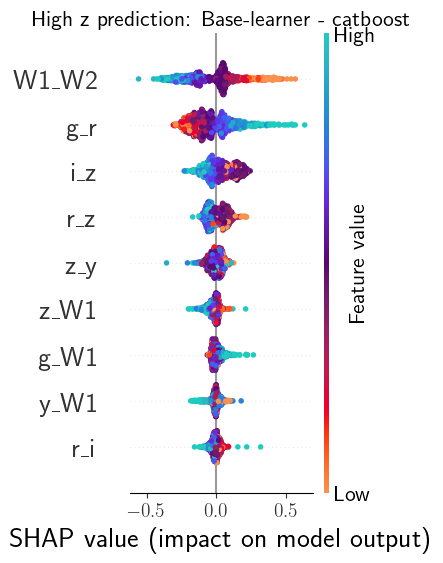

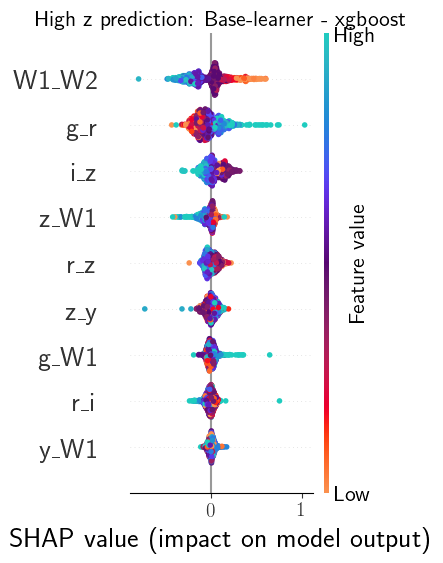

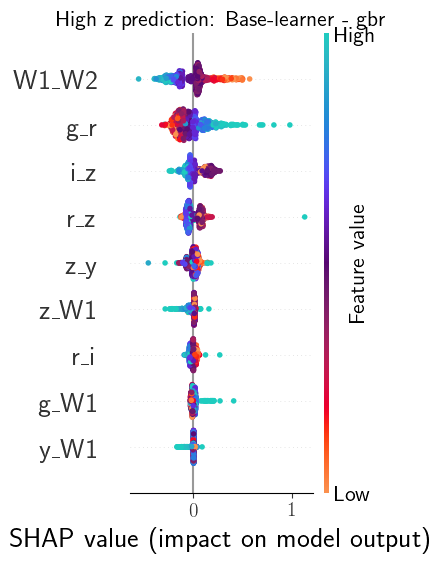

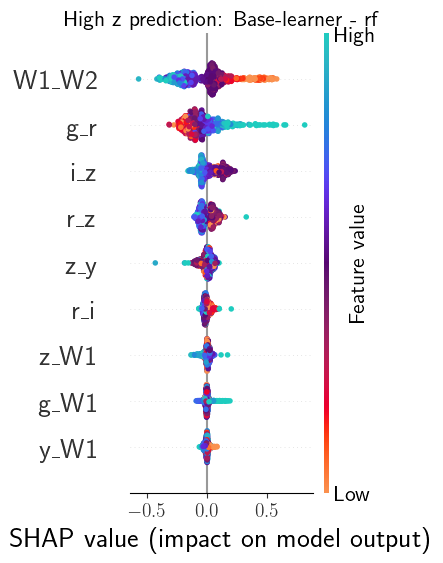

In [73]:
if run_shap_high_z_base & use_second_z_model:
    for model in shap_values_high_z_base.keys():
        gf.plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model], base_meta='Base')
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

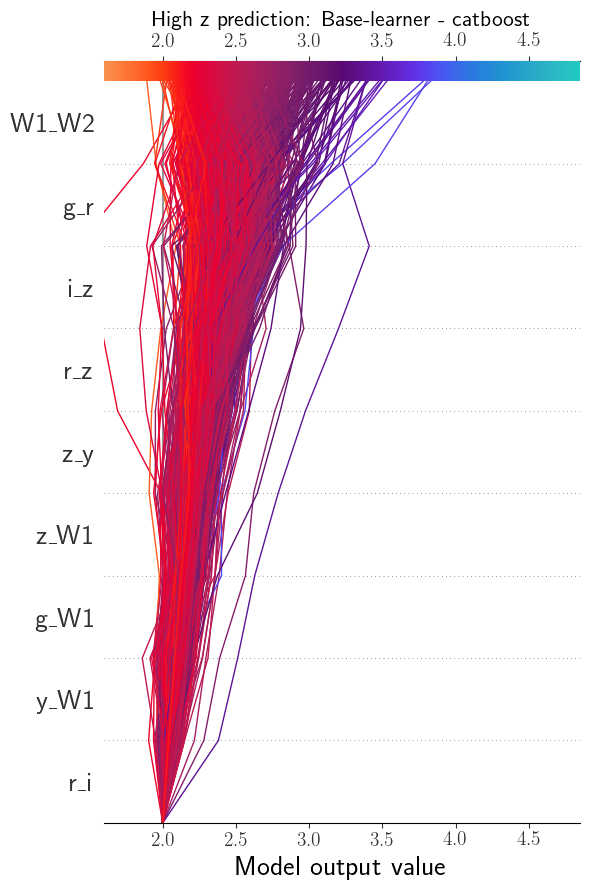

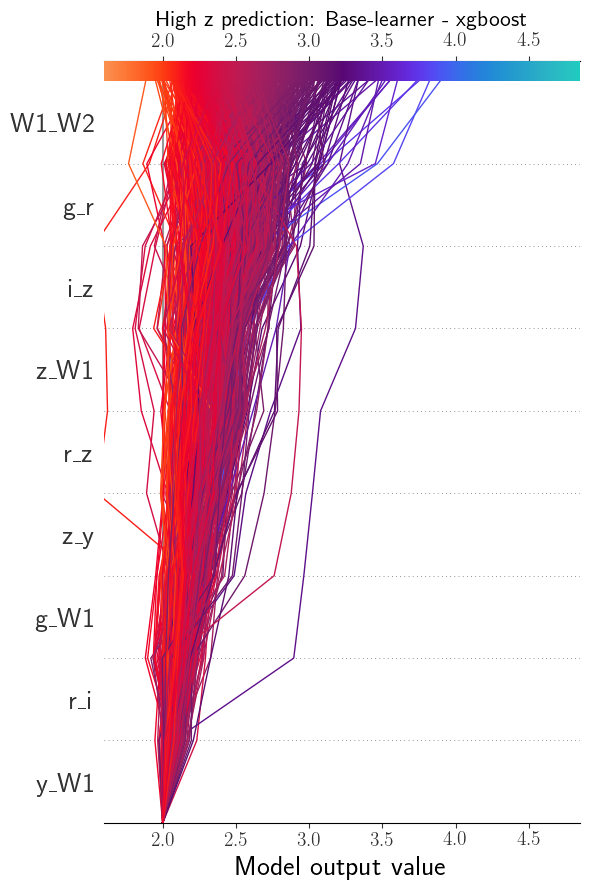

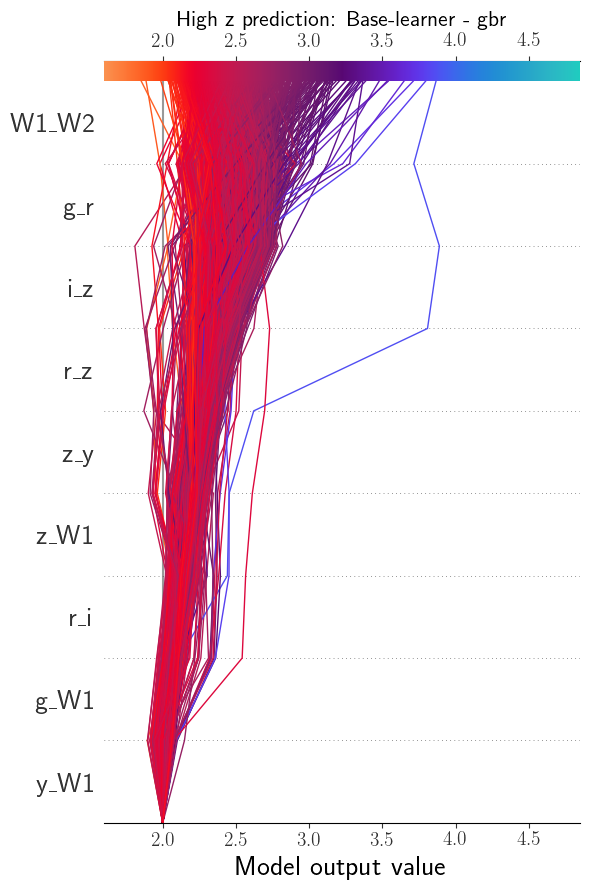

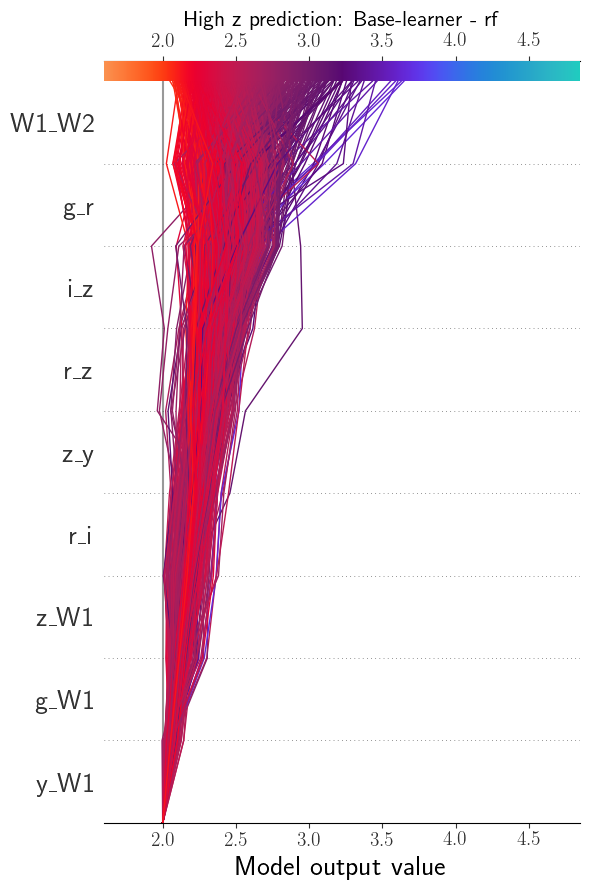

In [74]:
if run_shap_high_z_base & use_second_z_model:
    xlims_plt_hz    = (gv.high_z_limit - 0.4,\
                       full_catalog_df.loc[reduced_data_high_z_df.index, ['Z','pred_Z']].max().max() + 0.8)
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        _ = gf.plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                                  explainers_high_z_base[model], reduced_cols_high_z, ax1, 'identity',\
                                  new_base_value=gv.high_z_limit, base_meta='Base', xlim=xlims_plt_hz)
        if save_plot_flag:
            plt.savefig(gv.plots_path + f'SHAP_decision_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

catboost


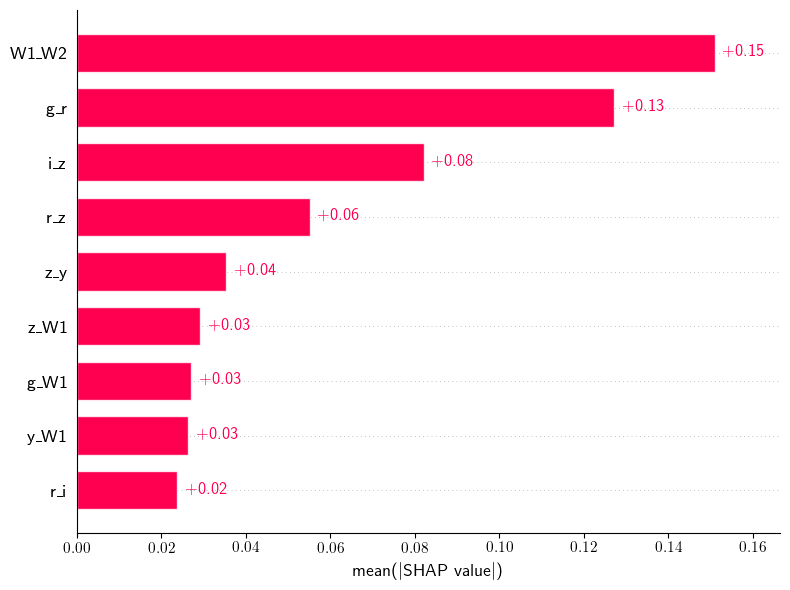

xgboost


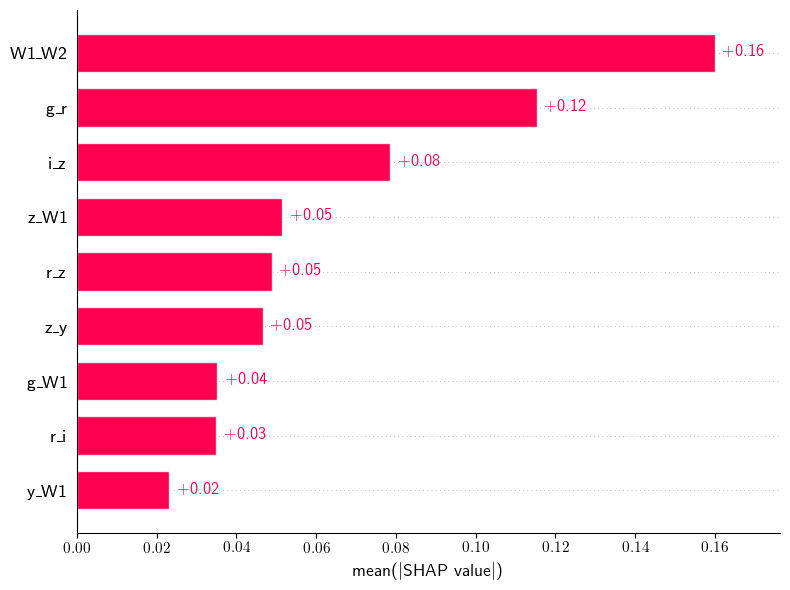

gbr


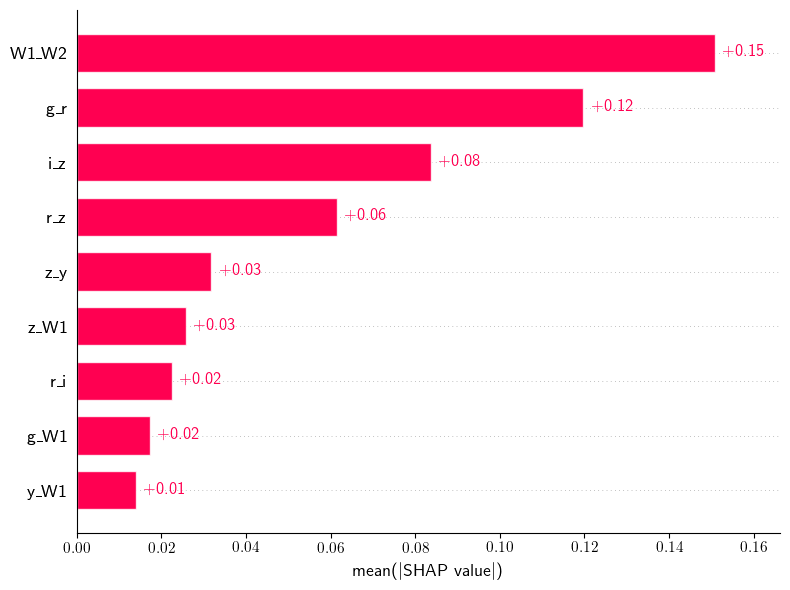

rf


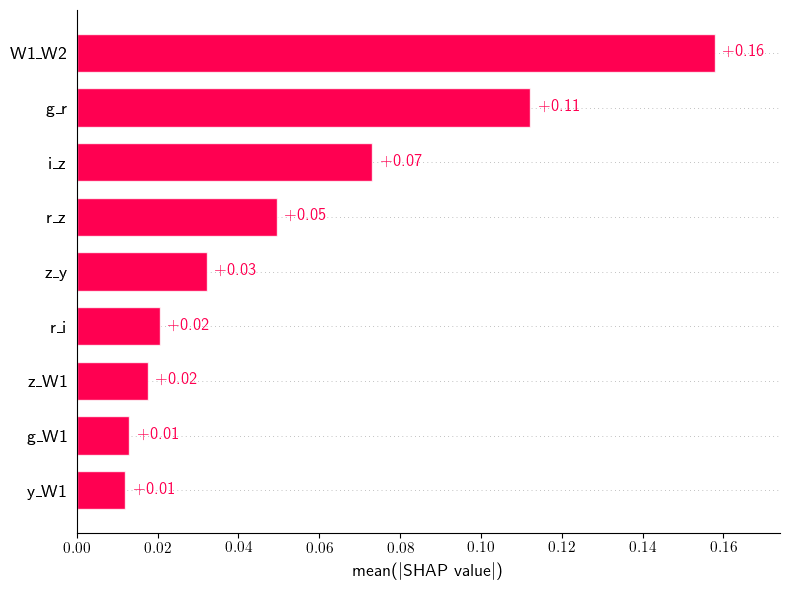

In [75]:
if run_shap_high_z_base & use_second_z_model:
    shp_copies_high_z = {}
    for model in shap_values_high_z_base.keys():
        # Convert from FastTreeShap to Shap object
        shp_copies_high_z[model] = shap.Explanation(values=shap_values_high_z_base[model].values,\
                                                    base_values=shap_values_high_z_base[model].base_values,\
                                                    data=shap_values_high_z_base[model].data,\
                                                    feature_names=shap_values_high_z_base[model].feature_names)
        print(f'{model}')
        if np.ndim(shp_copies_high_z[model].values) == 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model], max_display=None, show=False)
        elif np.ndim(shp_copies_high_z[model].values) > 2:
            shap.plots.bar(shap_values=shp_copies_high_z[model][:, :, 1], max_display=None, show=False)
        plt.gca().set_xlabel('mean($\\vert$SHAP value$\\vert$)')
        plt.tight_layout()
        plt.show()

In [76]:
if run_shap_high_z_base & use_second_z_model:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=base_models_name_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))


catboost:
2.28119
2.28119

xgboost:
2.14306
2.14307

gbr:
2.28896
2.28896

rf:
2.2919
2.2919
